# Análisis del perfil turístico que visitó Gran Canaria 2022

![Portada](https://www.holaislascanarias.com/sites/default/files/block-images/2021-06/Maspalomas.jpg)

El objetivo de este análisis es comprender las características demográficas, comportamientos, preferencias y patrones de los turistas en periodo de postpandemia, utilizando como base la encuesta de gasto turístico realizada por el Instituto Nacional de estadísticas (ISTAC).

A lo largo del análisis se emplean técnicas de exploración de datos (EDA) y herramientas de visualización desarrolladas en Python.

# **1.Preparación de los datos**


**Imports**
Se importan las librerias, módulos y funciones que vamos a usar a lo largo del análisis.

In [130]:
#Librerias que vamos a usar a lo largo del EDA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import stats, f_oneway, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sys
sys.path.append('utils')
import utils as funciones

# **1.2 Carga de la base de datos y visualización inicial**

Cargamos el dataset con el que vamos a trabajar

In [131]:
#Llamamos al csv y creamos el df de perfil turistico
df_perfil_turistico = pd.read_csv("./data/Perfil_turístico.csv", sep=";", encoding="latin1")

In [132]:
#Observamos sus primeras columnas
df_perfil_turistico.head()

Sexo  Edad Nacionalidad Viaja_solo Viaja_pareja Viaja_hijo Viaja_amigos  \
0     6    42       España         No           No         No           No   
1     1    27       España         No           Si         No           No   
2     6    63       Italia         Si           No         No           No   
3     6    43  Reino Unido         No           No         Si           No   
4     1    43       España         No           No         No           Si   

  Viaja_otros  Noches  Tipo_alojamiento  ...  Visitas_totales_Islas  \
0          Si       5                 3  ...                      2   
1          No       4                 4  ...                     10   
2          No       6                 3  ...                      1   
3          No       6                 4  ...                      1   
4          No       4                 4  ...                      3   

   Visitas_total_GC  Calificacion  Repetiria  Nivel_educativo  \
0                 2             4         10                4   
1                 3             3         10                4   
2                 1             1          1                4   
3                 1             4          9                4   
4                 2             4         10                4   

   Situacion_laboral  Ingresos  Personas_hogar  Cuatrimestre   Año  
0                  1         1               1            Q1  2019  
1                  1         2               2            Q1  2019  
2                  2         1               1            Q1  2019  
3                  5         3               4            Q1  2019  
4                  1         2               1            Q1  2019  

[5 rows x 24 columns]

# **1.3 Limpieza de los datos**

Hacemos el tratamiento de limpieza de los datos que sea necesario para su posterior uso.

In [133]:
#Limpieza de variables categóticas
# Se sabe que en la variable sexo 1=Hombre y 6=Mujer por lo que vamos a hacer la transformacion
df_perfil_turistico["Sexo"] = df_perfil_turistico["Sexo"].replace({1: "Hombre", 6: "Mujer"})

In [134]:
#Nivel educativo
df_perfil_turistico["Nivel_educativo"] = df_perfil_turistico["Nivel_educativo"].replace({1:"Sin estudios", 2:"Estudios primarios", 3:"Estudios secundarios", 4:"Estudios superiores"})

In [135]:
#Situacion laboral
df_perfil_turistico["Situacion_laboral"] = df_perfil_turistico["Situacion_laboral"].replace({ 1:"Asalariado", 2:"Autonomo", 3:"Empresario_peque", 4:"Empresario_grande",
5:"Desempleado", 6:"Estudiante", 7:"Jubilado", 8:"Incapacitado", 9:"Militar", 10:"Dependients", 11:"Otros"})


In [136]:
#Ingresos
df_perfil_turistico["Ingresos"] = df_perfil_turistico["Ingresos"].replace({1:"Menos 25.000", 2:"25.000-49.999",3:"50.000-74.999", 4:"+75.000"})

In [137]:
#Tipo de alojamiento
df_perfil_turistico["Tipo_alojamiento"] = df_perfil_turistico["Tipo_alojamiento"].replace({1:"Hotel 1-2-3*", 2:"Hotel 4*",3:"Hotel 5*", 4:"Apartamento/Villa", 5:"Vivienda/airbnb", 6:"Alojamiento privado", 7:"Alojamiento rural"})

In [138]:
#Repetiría
df_perfil_turistico["Repetiria"] = df_perfil_turistico["Repetiria"].replace({1:"(1)", 2:"(2)",3:"(3)", 4:"(4)", 5:"(5)", 6:"(6)", 7:"(7)",8:"(8)",9:"(9)",10:"(10)"})

In [139]:
#Calificacion
df_perfil_turistico["Calificacion"] = df_perfil_turistico["Calificacion"].replace({1:"Mucho peor de lo esperado", 2:"Peor de lo esperado",3:"A la altura de las expectativas", 4:"Mejor de lo esperado", 5:"Mucho mejor de lo esperado"})

In [140]:
#Creamos una columna con el tipo de aconmpañante
columnas_tipo_acompañante = ["Viaja_solo", "Viaja_pareja", "Viaja_hijo", "Viaja_amigos", "Viaja_otros"]

# Crear la columna "Resultado" solo basándose en esas columnas
df_perfil_turistico["Modo_viaje"] = df_perfil_turistico.apply(lambda row: ', '.join(col for col in columnas_tipo_acompañante if row[col] == "Si"), axis=1)


In [141]:
#Eliminamos la columna Tipo de viaje
df_perfil_turistico = df_perfil_turistico.drop(columns=["Viaja_pareja","Viaja_hijo","Viaja_otros","Viaja_solo","Viaja_amigos"])

In [142]:
df_perfil_turistico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12295 entries, 0 to 12294
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sexo                     12295 non-null  object 
 1   Edad                     12295 non-null  int64  
 2   Nacionalidad             12295 non-null  object 
 3   Noches                   12295 non-null  int64  
 4   Tipo_alojamiento         12295 non-null  object 
 5   Coste_vuelos             12295 non-null  float64
 6   Coste_alojamiento        12295 non-null  float64
 7   Gastos                   12295 non-null  float64
 8   Horas_fuera_alojamiento  12295 non-null  int64  
 9   Visitas_totales_Islas    12295 non-null  int64  
 10  Visitas_total_GC         12295 non-null  int64  
 11  Calificacion             12295 non-null  object 
 12  Repetiria                12295 non-null  object 
 13  Nivel_educativo          12295 non-null  object 
 14  Situacion_laboral     

In [143]:
# Convertir algunas columnas a float
df_perfil_turistico['Edad'] = df_perfil_turistico['Edad'].astype(float)
df_perfil_turistico['Noches'] = df_perfil_turistico['Noches'].astype(float)
df_perfil_turistico['Personas_hogar'] = df_perfil_turistico['Personas_hogar'].astype(float)
# Verificar el cambio
df_perfil_turistico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12295 entries, 0 to 12294
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sexo                     12295 non-null  object 
 1   Edad                     12295 non-null  float64
 2   Nacionalidad             12295 non-null  object 
 3   Noches                   12295 non-null  float64
 4   Tipo_alojamiento         12295 non-null  object 
 5   Coste_vuelos             12295 non-null  float64
 6   Coste_alojamiento        12295 non-null  float64
 7   Gastos                   12295 non-null  float64
 8   Horas_fuera_alojamiento  12295 non-null  int64  
 9   Visitas_totales_Islas    12295 non-null  int64  
 10  Visitas_total_GC         12295 non-null  int64  
 11  Calificacion             12295 non-null  object 
 12  Repetiria                12295 non-null  object 
 13  Nivel_educativo          12295 non-null  object 
 14  Situacion_laboral     

In [144]:
#¿Valores duplicados?
df_perfil_turistico.duplicated(keep=False)
len(df_perfil_turistico[df_perfil_turistico.duplicated(keep = False)]) # keep = "first", keep = False

0

In [145]:
#¿Valores nulos?
df_perfil_turistico.isnull()
df_perfil_turistico.isnull().sum()

Sexo                       0
Edad                       0
Nacionalidad               0
Noches                     0
Tipo_alojamiento           0
Coste_vuelos               0
Coste_alojamiento          0
Gastos                     0
Horas_fuera_alojamiento    0
Visitas_totales_Islas      0
Visitas_total_GC           0
Calificacion               0
Repetiria                  0
Nivel_educativo            0
Situacion_laboral          0
Ingresos                   0
Personas_hogar             0
Cuatrimestre               0
Año                        0
Modo_viaje                 0
dtype: int64

In [146]:
#¿Outliers?
variables_numericas=["Edad","Noches","Coste_vuelos","Coste_alojamiento","Gastos","Horas_fuera_alojamiento","Visitas_totales_Islas","Visitas_total_GC","Personas_hogar"]

In [147]:
# Calcular límites inferior y superior
outliers = {}
for var in variables_numericas:
    q1 = df_perfil_turistico[var].quantile(0.25)
    q3 = df_perfil_turistico[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identificar outliers
    outliers[var] = df_perfil_turistico[(df_perfil_turistico[var] < lower_bound) | (df_perfil_turistico[var] > upper_bound)]

    #print(f"Outliers en {var}:\n{outliers[var]}")

Reemplazar outliers con la mediana ya que mantiene la tendencia central del conjunto de datos si que los valores extremos sesgen los resultados


In [148]:
# Reemplazar valores fuera del rango por la mediana
for var in variables_numericas:
    q1 = df_perfil_turistico[var].quantile(0.25)
    q3 = df_perfil_turistico[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    median = df_perfil_turistico[var].median()
    df_perfil_turistico[var] = df_perfil_turistico[var].apply(lambda x: median if (x < lower_bound or x > upper_bound) else x)

In [149]:
#Vemos el total de columnas
df_perfil_turistico.columns

Index(['Sexo', 'Edad', 'Nacionalidad', 'Noches', 'Tipo_alojamiento',
       'Coste_vuelos', 'Coste_alojamiento', 'Gastos',
       'Horas_fuera_alojamiento', 'Visitas_totales_Islas', 'Visitas_total_GC',
       'Calificacion', 'Repetiria', 'Nivel_educativo', 'Situacion_laboral',
       'Ingresos', 'Personas_hogar', 'Cuatrimestre', 'Año', 'Modo_viaje'],
      dtype='object')

In [150]:
df_perfil_turistico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12295 entries, 0 to 12294
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sexo                     12295 non-null  object 
 1   Edad                     12295 non-null  float64
 2   Nacionalidad             12295 non-null  object 
 3   Noches                   12295 non-null  float64
 4   Tipo_alojamiento         12295 non-null  object 
 5   Coste_vuelos             12295 non-null  float64
 6   Coste_alojamiento        12295 non-null  float64
 7   Gastos                   12295 non-null  float64
 8   Horas_fuera_alojamiento  12295 non-null  float64
 9   Visitas_totales_Islas    12295 non-null  float64
 10  Visitas_total_GC         12295 non-null  float64
 11  Calificacion             12295 non-null  object 
 12  Repetiria                12295 non-null  object 
 13  Nivel_educativo          12295 non-null  object 
 14  Situacion_laboral     

Los datos ya han sido limpiados y están listos para comenzar con el análisis.

Comencemos por explorar la tipología de las variables, definiendo su cardinalidad para proceder con su posterior clasificación

In [151]:
# Calculemos ahora su cardinalidad
cardinalidad = round((df_perfil_turistico.nunique() /len (df_perfil_turistico))*100,2)
cardinalidad


Sexo                        0.02
Edad                        0.58
Nacionalidad                0.11
Noches                      0.10
Tipo_alojamiento            0.06
Coste_vuelos               18.28
Coste_alojamiento          24.14
Gastos                     16.03
Horas_fuera_alojamiento     0.16
Visitas_totales_Islas       0.14
Visitas_total_GC            0.10
Calificacion                0.04
Repetiria                   0.09
Nivel_educativo             0.03
Situacion_laboral           0.09
Ingresos                    0.03
Personas_hogar              0.03
Cuatrimestre                0.03
Año                         0.02
Modo_viaje                  0.04
dtype: float64

In [152]:
# Calculemos ahora su cardinalidad
funciones.cardi(df_perfil_turistico,15,65)

Cardi    % Cardi      Clasificacion
Sexo                         2   0.016267            Binaria
Edad                        71   0.577471  Numerica Discreta
Nacionalidad                14   0.113867         Categorica
Noches                      12   0.097601         Categorica
Tipo_alojamiento             7   0.056934         Categorica
Coste_vuelos              2248  18.283855  Numerica Discreta
Coste_alojamiento         2968  24.139894  Numerica Discreta
Gastos                    1971  16.030907  Numerica Discreta
Horas_fuera_alojamiento     20   0.162668  Numerica Discreta
Visitas_totales_Islas       17   0.138268  Numerica Discreta
Visitas_total_GC            12   0.097601         Categorica
Calificacion                 5   0.040667         Categorica
Repetiria                   11   0.089467         Categorica
Nivel_educativo              4   0.032534         Categorica
Situacion_laboral           11   0.089467         Categorica
Ingresos                     4   0.032534         Categorica
Personas_hogar               4   0.032534         Categorica
Cuatrimestre                 4   0.032534         Categorica
Año                          2   0.016267            Binaria
Modo_viaje                   5   0.040667         Categorica

# **2. Análisis**

Una vez determinada la cardinalidad, podemos comprender mejor las variables y definirlas en la siguiente tabla. Esta tabla nos servirá como guía para identificar cada variable y aplicar el análisis adecuado a cada una de ellas.

|Variable|Descripción|Tipo_de_Variable|Importancia inicial|Nota|
|-|-|-|-|-|
|Sexo| Hombre o mujer|Binaria|1|Explica análisis demográfico|
|Edad| Edad del encuestado|Numérica Discreta|1|Explica análisis demográfico|
|Nacionalidad|Nacionalidad del turista|Categórica|1|Explica análisis demográfico|
|Noches|Número de noches que pernoctó en la isla|Númerica Discreta|1|Define el comportamiento del gasto|
|Tipo_alojamiento| Tipo de alojamiento que se hospedó|Categórica|1|Define el comportamiento del gasto|
|Coste_vuelos|Coste en euros del billete de avión|Numérica Discreta|1|Define el comportamiento del gasto|
|Coste_alojamiento|Coste en euros de las noches alojadas|Numérica Discreta|1|Define el comportamiento del gasto|
|Gasto| Gasto del turista en su estancia en la isla|Numérica Discreta|1|Define el comportamiento del gasto|
|Horas_fuera_alojamiento| Horas fuera del alojamiento|Numérica discreta|3|Comportamiento durante la estancia|
|Visitas_totales_Islas| Número de veces que ha visitados las Islas Canarias|Numérica Discreta|2|Comportamiento durante la estancia|
|Visitas_total_GC| Número de veces que ha estado en Gran Canaria|Numérica Discreta|2|Comportamiento durante la estancia|
|Calificacion| Definida en 5 categorías|Categórica|2|Comportamiento durante la estancia|
|Repetiria| Del 1-10 el valor de repetición|Categórica|2|Comportamiento durante la estancia|
|Nivel_educativo| Nivel educativo|Categórica|1|Explica análisis demográfico|
|Situacion_laboral| Situación laboral|Categórica|1|Explica análisis demográfico|
|Ingresos| Ingresos por tramos, del turista|Categórica|1|Explica análisis demográfico|
|Personas_hogar| Número de personas del hogar |Numérica Discreta|1|Explica análisis demográfico|
|Cuatrimestre| Cuatrimestre de estudio|Categórica|1|Temporadas del estudio|
|Año| 2019 -2022|Binaria|1|Define los datos antes y después de pandemia|
|Modo viaje| Tipo de acompañante|Categórica|1|Define el comportamiento del gasto|

# **2.1Análisis Univariante**

# *Variables Categóricas*

Análisis univariante de las variables categóricas, para este análisis, vamos a dividir la muestra en dos, es decir, un df para el 2019 y otro para el 2022 para tener definido las variables antes y después de pandemia.

In [153]:
#Datos prepandemia
df_2019 = df_perfil_turistico[df_perfil_turistico['Año'] == 2019]
#Datos postpandemia
df_2022 = df_perfil_turistico[df_perfil_turistico['Año'] == 2022]

In [154]:
#Variables categóricas 
variables_categoricas=["Sexo","Nacionalidad","Tipo_alojamiento","Calificacion","Repetiria","Nivel_educativo","Situacion_laboral","Ingresos", "Modo_viaje"]

In [155]:
#Perfil del turista 2019
df_2019[variables_categoricas].mode().T

0
Sexo                                         Mujer
Nacionalidad                              Alemania
Tipo_alojamiento                          Hotel 4*
Calificacion       A la altura de las expectativas
Repetiria                                     (10)
Nivel_educativo                Estudios superiores
Situacion_laboral                       Asalariado
Ingresos                             25.000-49.999
Modo_viaje                            Viaja_pareja

In [156]:
#Perfil del turista 2022
df_2022[variables_categoricas].mode().T

0
Sexo                                         Mujer
Nacionalidad                                España
Tipo_alojamiento                          Hotel 4*
Calificacion       A la altura de las expectativas
Repetiria                                     (10)
Nivel_educativo                Estudios superiores
Situacion_laboral                       Asalariado
Ingresos                             25.000-49.999
Modo_viaje                            Viaja_pareja

***Antes de pandemia:***
La moda revela que el perfil predominante del turista es el de una mujer procedente de Alemania. Este turista se aloja en hoteles de cuatro estrellas, disfruta de su estancia, alcanzando sus expectativas, y, sin duda recomendaría el destino. Su perfil suele incluir estudios superiores y un nivel de ingresos de entre 25.000 y 50.000 euros. Generalmente, viaja en pareja, habiendo visitado las islas previamente.

***Post pandemia:***
El perfil se mantiene igual, solo cambia que la procedencia sea más común desde España. 

Este análisis preliminar concluye que se ha producido un cambio en el comportamiento respecto a la nacionalidad de origen del turista, mientras que el resto de las características del perfil se mantienen sin variaciones. Este fenómeno puede explicarse por las restricciones aplicadas en los distintos países, que, junto con la proximidad geográfica, hicieron que para el turista español fuera más sencillo viajar a la isla en comparación con turistas de otras nacionalidades.

***Análisis de frecuencias absolutas y relativas***

Para este estudio, debido a la cantidad de variables, es mejor verlo de manera gráfica

# **Gráficos variables categóricas**
Valores relativos

**2019**

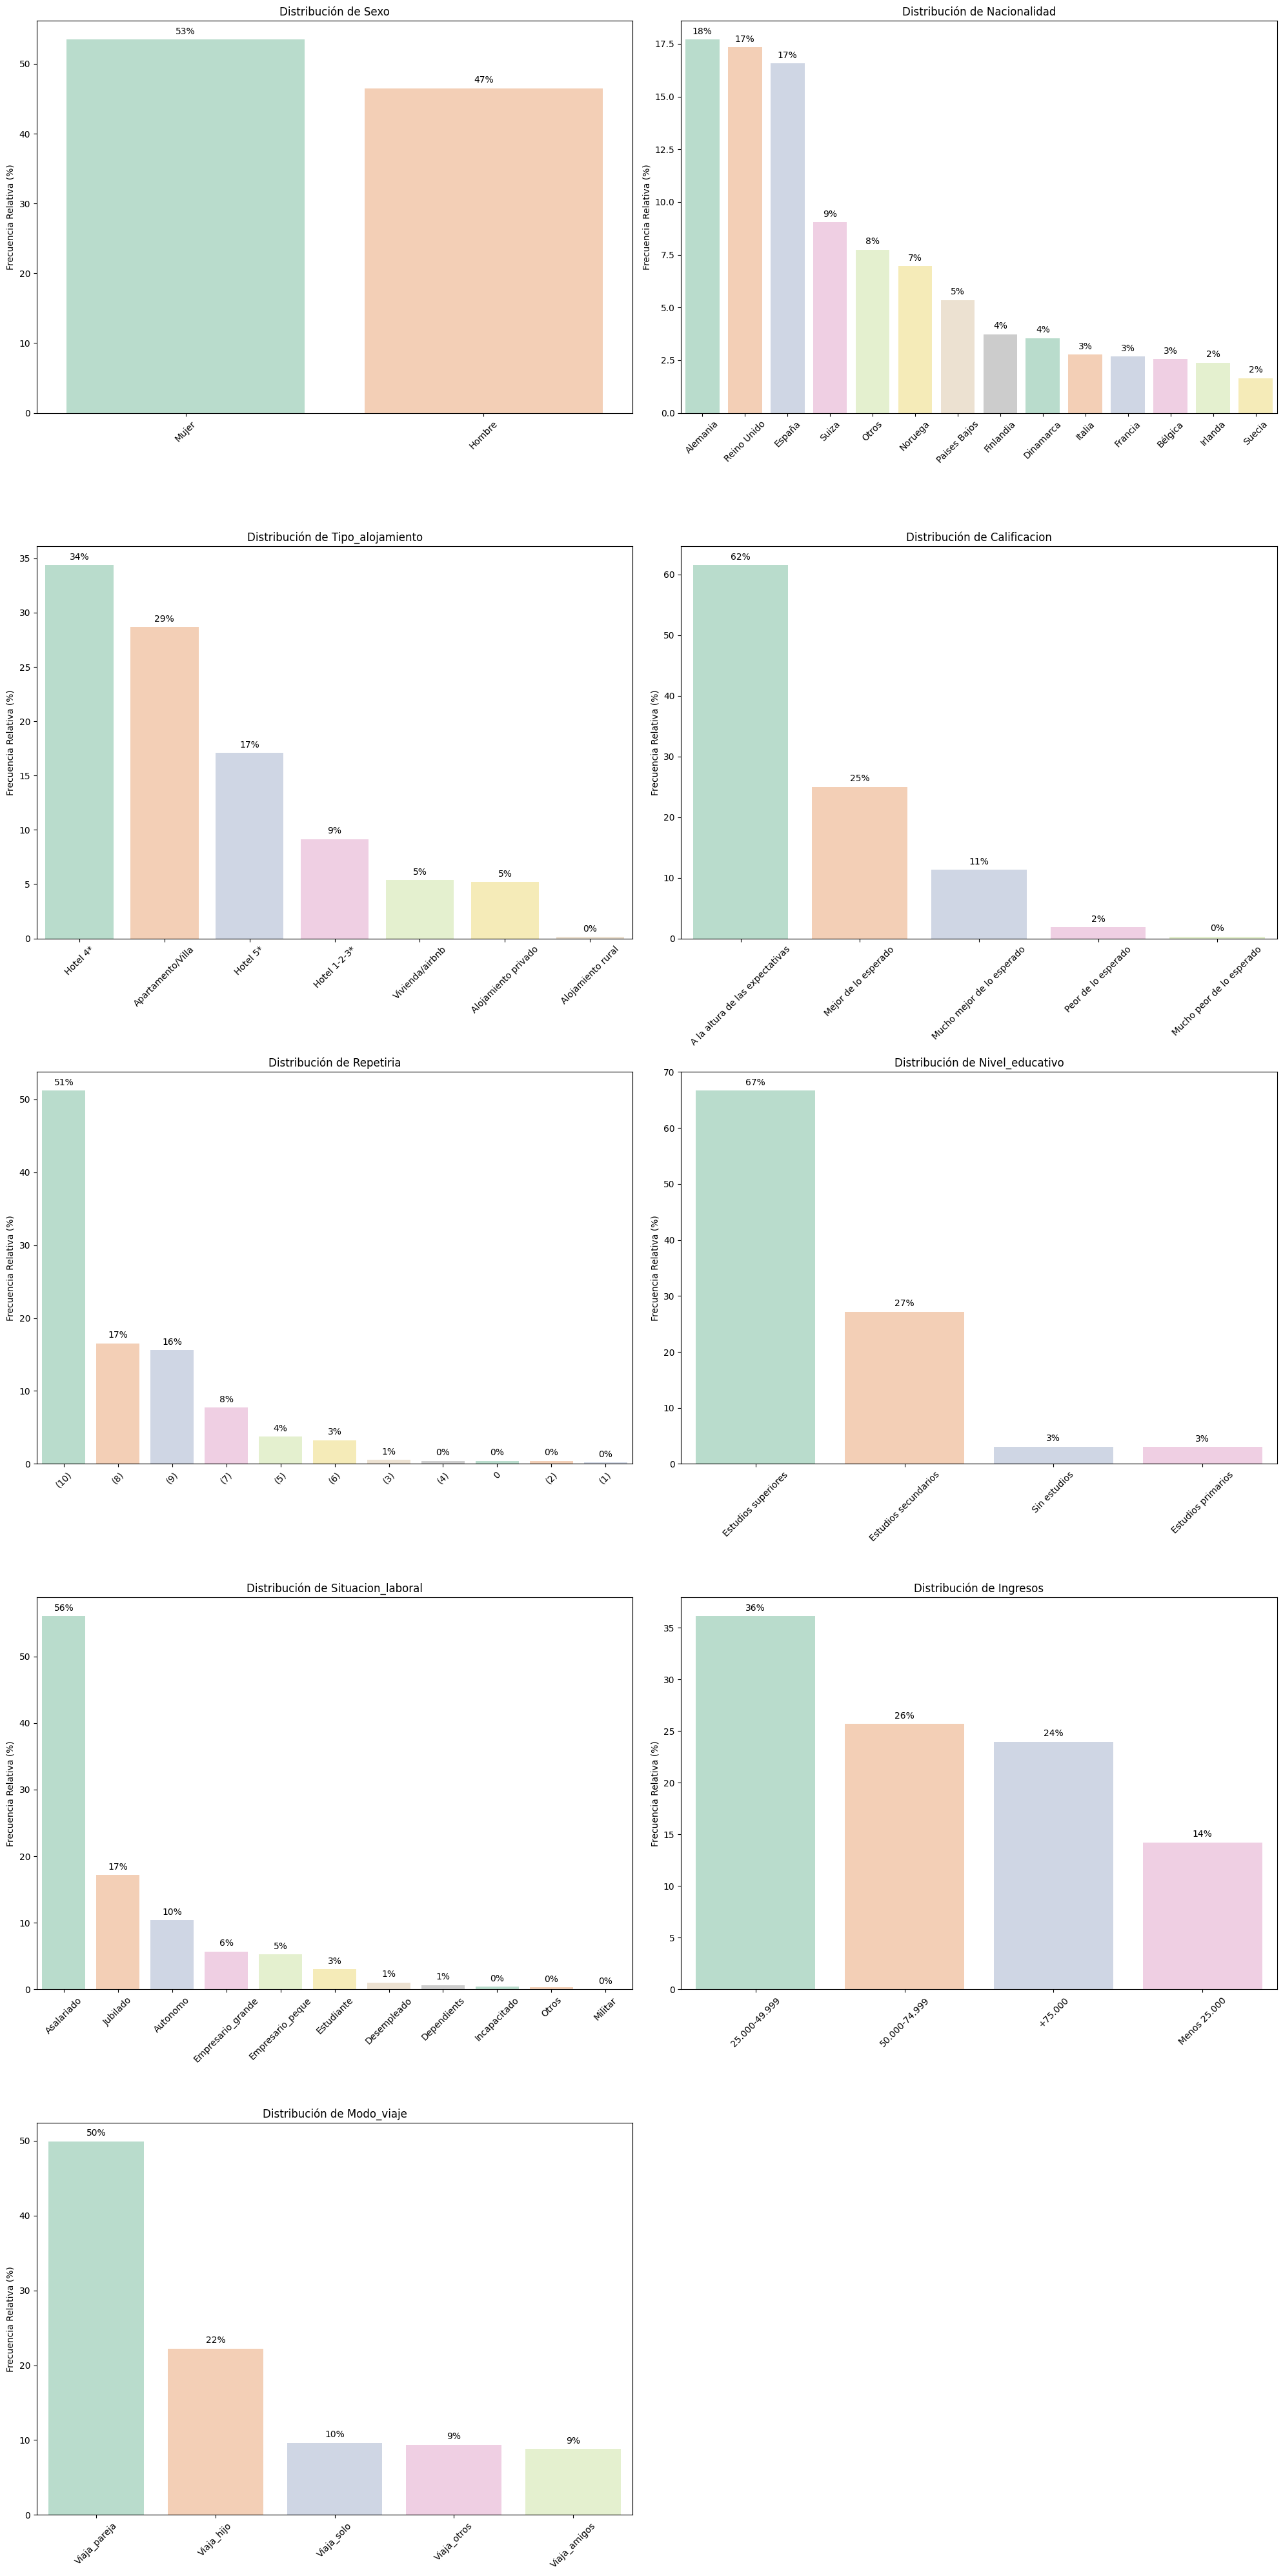

In [157]:
funciones.pinta_distribucion_categoricas(df_2019,variables_categoricas,relativa=True,mostrar_valores=True)

**2022**


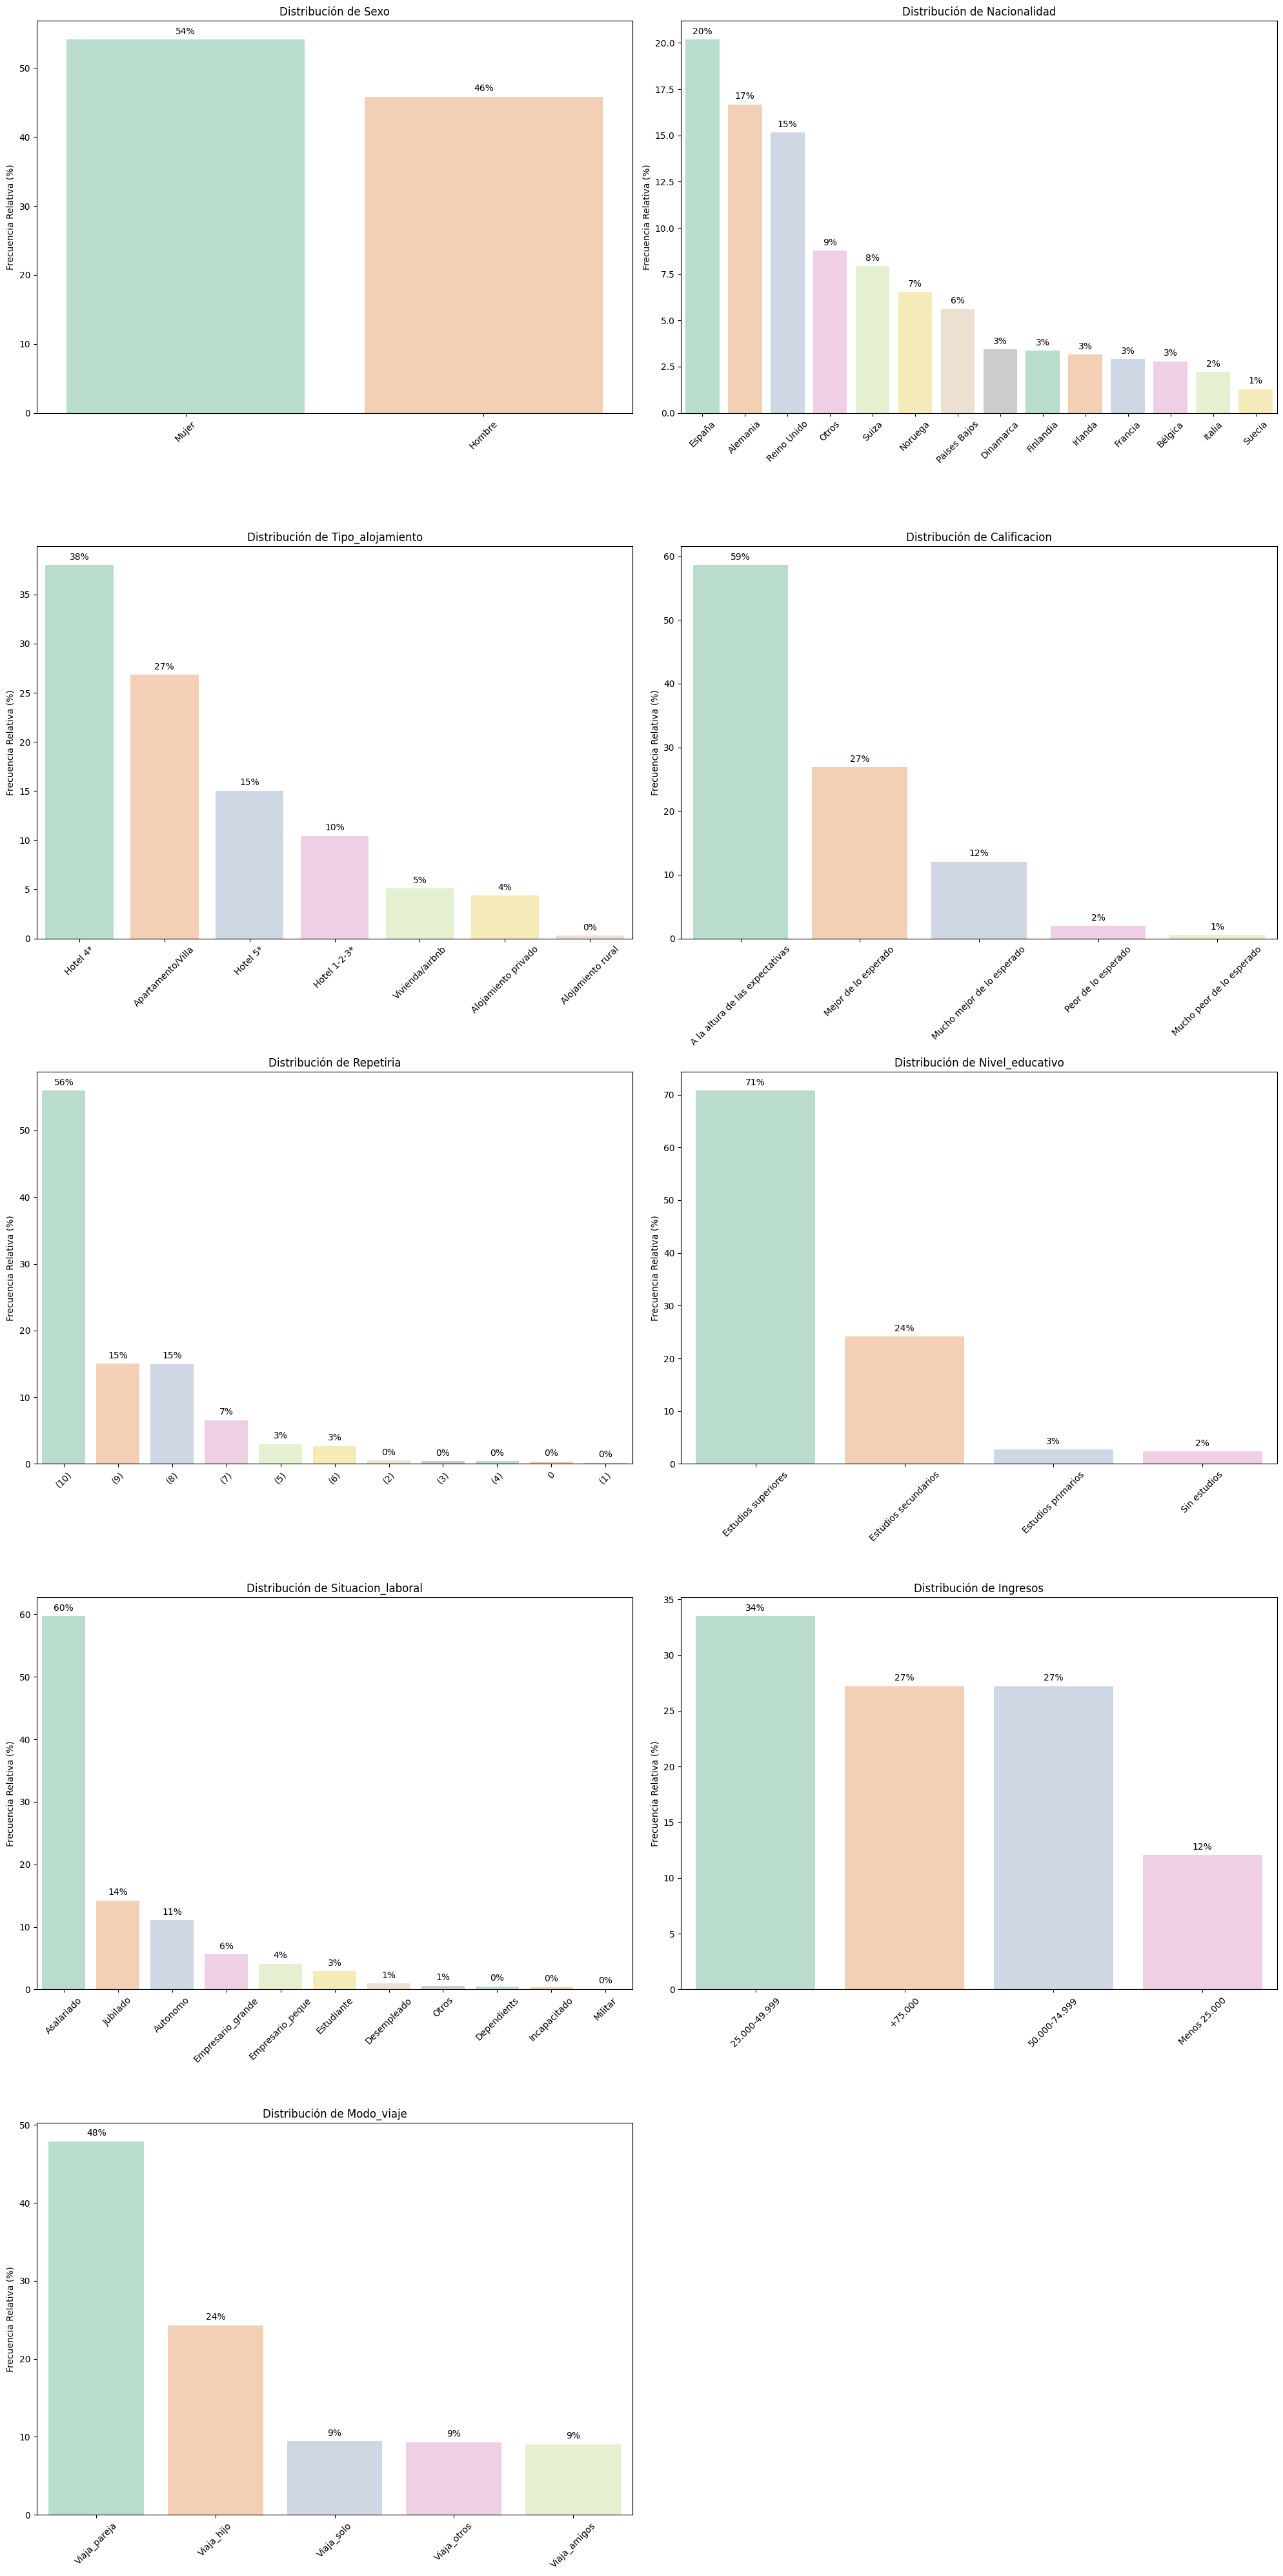

In [158]:
funciones.pinta_distribucion_categoricas(df_2022,variables_categoricas,relativa=True,mostrar_valores=True)

**Resumen analisis univariante de las variables categóricas:**

|Variables|Categoría|2019|2022|
|-|-|-|-|
|Sexo| Mujer| 53% |54% |
|Nacionalidad| Alemania - España |18% - 17%|20% -17% |
|Tipo de alojamiento| Hotel 4*| 34%| 38%|
|Calificación| 10| 62%| 59%|
|Repetiría| 10| 51%| 56%|
|Nivel educativo| Estudios superiores| 67%| 71%|
|Situación laboral| Asalariados| 56%| 60%|
|Ingresos| 25.000-49.999| 36%| 34%|
|Modo_viaje| Pareja| 50%| 48%|

# **2.2 Variables numéricas**

In [159]:
#Variables numéricas
variables_numericas=["Edad","Noches","Coste_vuelos","Coste_alojamiento","Gastos","Horas_fuera_alojamiento","Visitas_totales_Islas","Visitas_total_GC","Personas_hogar"]

In [160]:
#Principales estadísticos en 2019
df_2019.describe()

Edad       Noches  Coste_vuelos  Coste_alojamiento       Gastos  \
count  6061.000000  6061.000000   6061.000000        6061.000000  6061.000000   
mean     47.726283     7.975747    366.042686         287.616715   360.302976   
std      14.614298     2.651963    298.708511         334.737851   279.043028   
min      16.000000     3.000000      1.000000           1.000000     0.000000   
25%      37.000000     7.000000     10.000000           1.592000   115.000000   
50%      48.000000     7.000000    349.000000          60.000000   338.000000   
75%      58.000000     9.000000    600.000000         585.000000   567.000000   
max      87.000000    14.000000    999.000000         999.000000   999.000000   

       Horas_fuera_alojamiento  Visitas_totales_Islas  Visitas_total_GC  \
count              6061.000000            6061.000000       6061.000000   
mean                  7.215476               5.016994          2.812572   
std                   3.942085               3.562623          2.510804   
min                   0.000000               1.000000          0.000000   
25%                   4.000000               2.000000          1.000000   
50%                   7.000000               4.000000          2.000000   
75%                  10.000000               7.000000          4.000000   
max                  19.000000              17.000000         11.000000   

       Personas_hogar     Año  
count     6061.000000  6061.0  
mean         2.359677  2019.0  
std          0.915930     0.0  
min          1.000000  2019.0  
25%          2.000000  2019.0  
50%          2.000000  2019.0  
75%          3.000000  2019.0  
max          4.000000  2019.0

Edad y duración de la estancia: La edad media del turista es de 48 años, y su estancia promedio en la isla es de 8 noches.

Costes y visitas: El coste medio de los vuelos es de 366€, mientras que el gasto en alojamiento asciende a 287€ y su gasto medio en la durante su estancia es de 360€. En promedio, los turistas han visitado las Islas Canarias unas 7 veces y, en particular, Gran Canaria en 3 ocasiones.

Composición del hogar y tiempo fuera del alojamiento: El hogar promedio de estos turistas está compuesto por 3 persona, y pasan un promedio de 8 horas al día fuera del alojamiento.

In [161]:
#Principales estadísticos en 2022
df_2022.describe()

Edad       Noches  Coste_vuelos  Coste_alojamiento       Gastos  \
count  6234.000000  6234.000000   6234.000000        6234.000000  6234.000000   
mean     48.074110     7.880173    351.804917         234.945677   341.690813   
std      14.262611     2.648372    310.289803         322.943185   294.716489   
min      16.000000     3.000000      1.000000           1.000000     0.000000   
25%      38.000000     7.000000      2.132250           1.571250     2.403000   
50%      49.000000     7.000000    320.000000           2.949500   313.000000   
75%      58.000000     9.000000    600.000000         493.000000   580.000000   
max      85.000000    14.000000    999.000000         999.000000   999.000000   

       Horas_fuera_alojamiento  Visitas_totales_Islas  Visitas_total_GC  \
count              6234.000000            6234.000000       6234.000000   
mean                  6.757940               5.069137          2.706449   
std                   3.779451               3.589859          2.424036   
min                   0.000000               1.000000          0.000000   
25%                   4.000000               2.000000          1.000000   
50%                   6.000000               4.000000          2.000000   
75%                  10.000000               7.000000          3.000000   
max                  15.000000              17.000000         11.000000   

       Personas_hogar     Año  
count     6234.000000  6234.0  
mean         2.325634  2022.0  
std          0.923251     0.0  
min          1.000000  2022.0  
25%          2.000000  2022.0  
50%          2.000000  2022.0  
75%          3.000000  2022.0  
max          4.000000  2022.0

Edad y duración de la estancia: La edad media del turista es de 48 años, y su estancia promedio en la isla es de 9 noches.

Costes y visitas: El coste medio de los vuelos es de 352€, mientras que el gasto en alojamiento asciende a 235€ y su gasto durante las vacaciones es de 342€ de media. En promedio, los turistas han visitado las Islas Canarias unas 5 veces y, en particular, Gran Canaria en 3 ocasiones.

Composición del hogar y tiempo fuera del alojamiento: El hogar promedio de estos turistas está compuesto por 3 persona, y pasan un promedio de 6 horas al día fuera del alojamiento.

A diferencia del 2019, si hay una disminucion en las horas medias que los turistas pasan fuera del alojaminendo siendo 6h de media en el 2022, puede tener relación con las restricciones sanitarias y la inseguridad de la exposición en zonas de aglomeraciones.

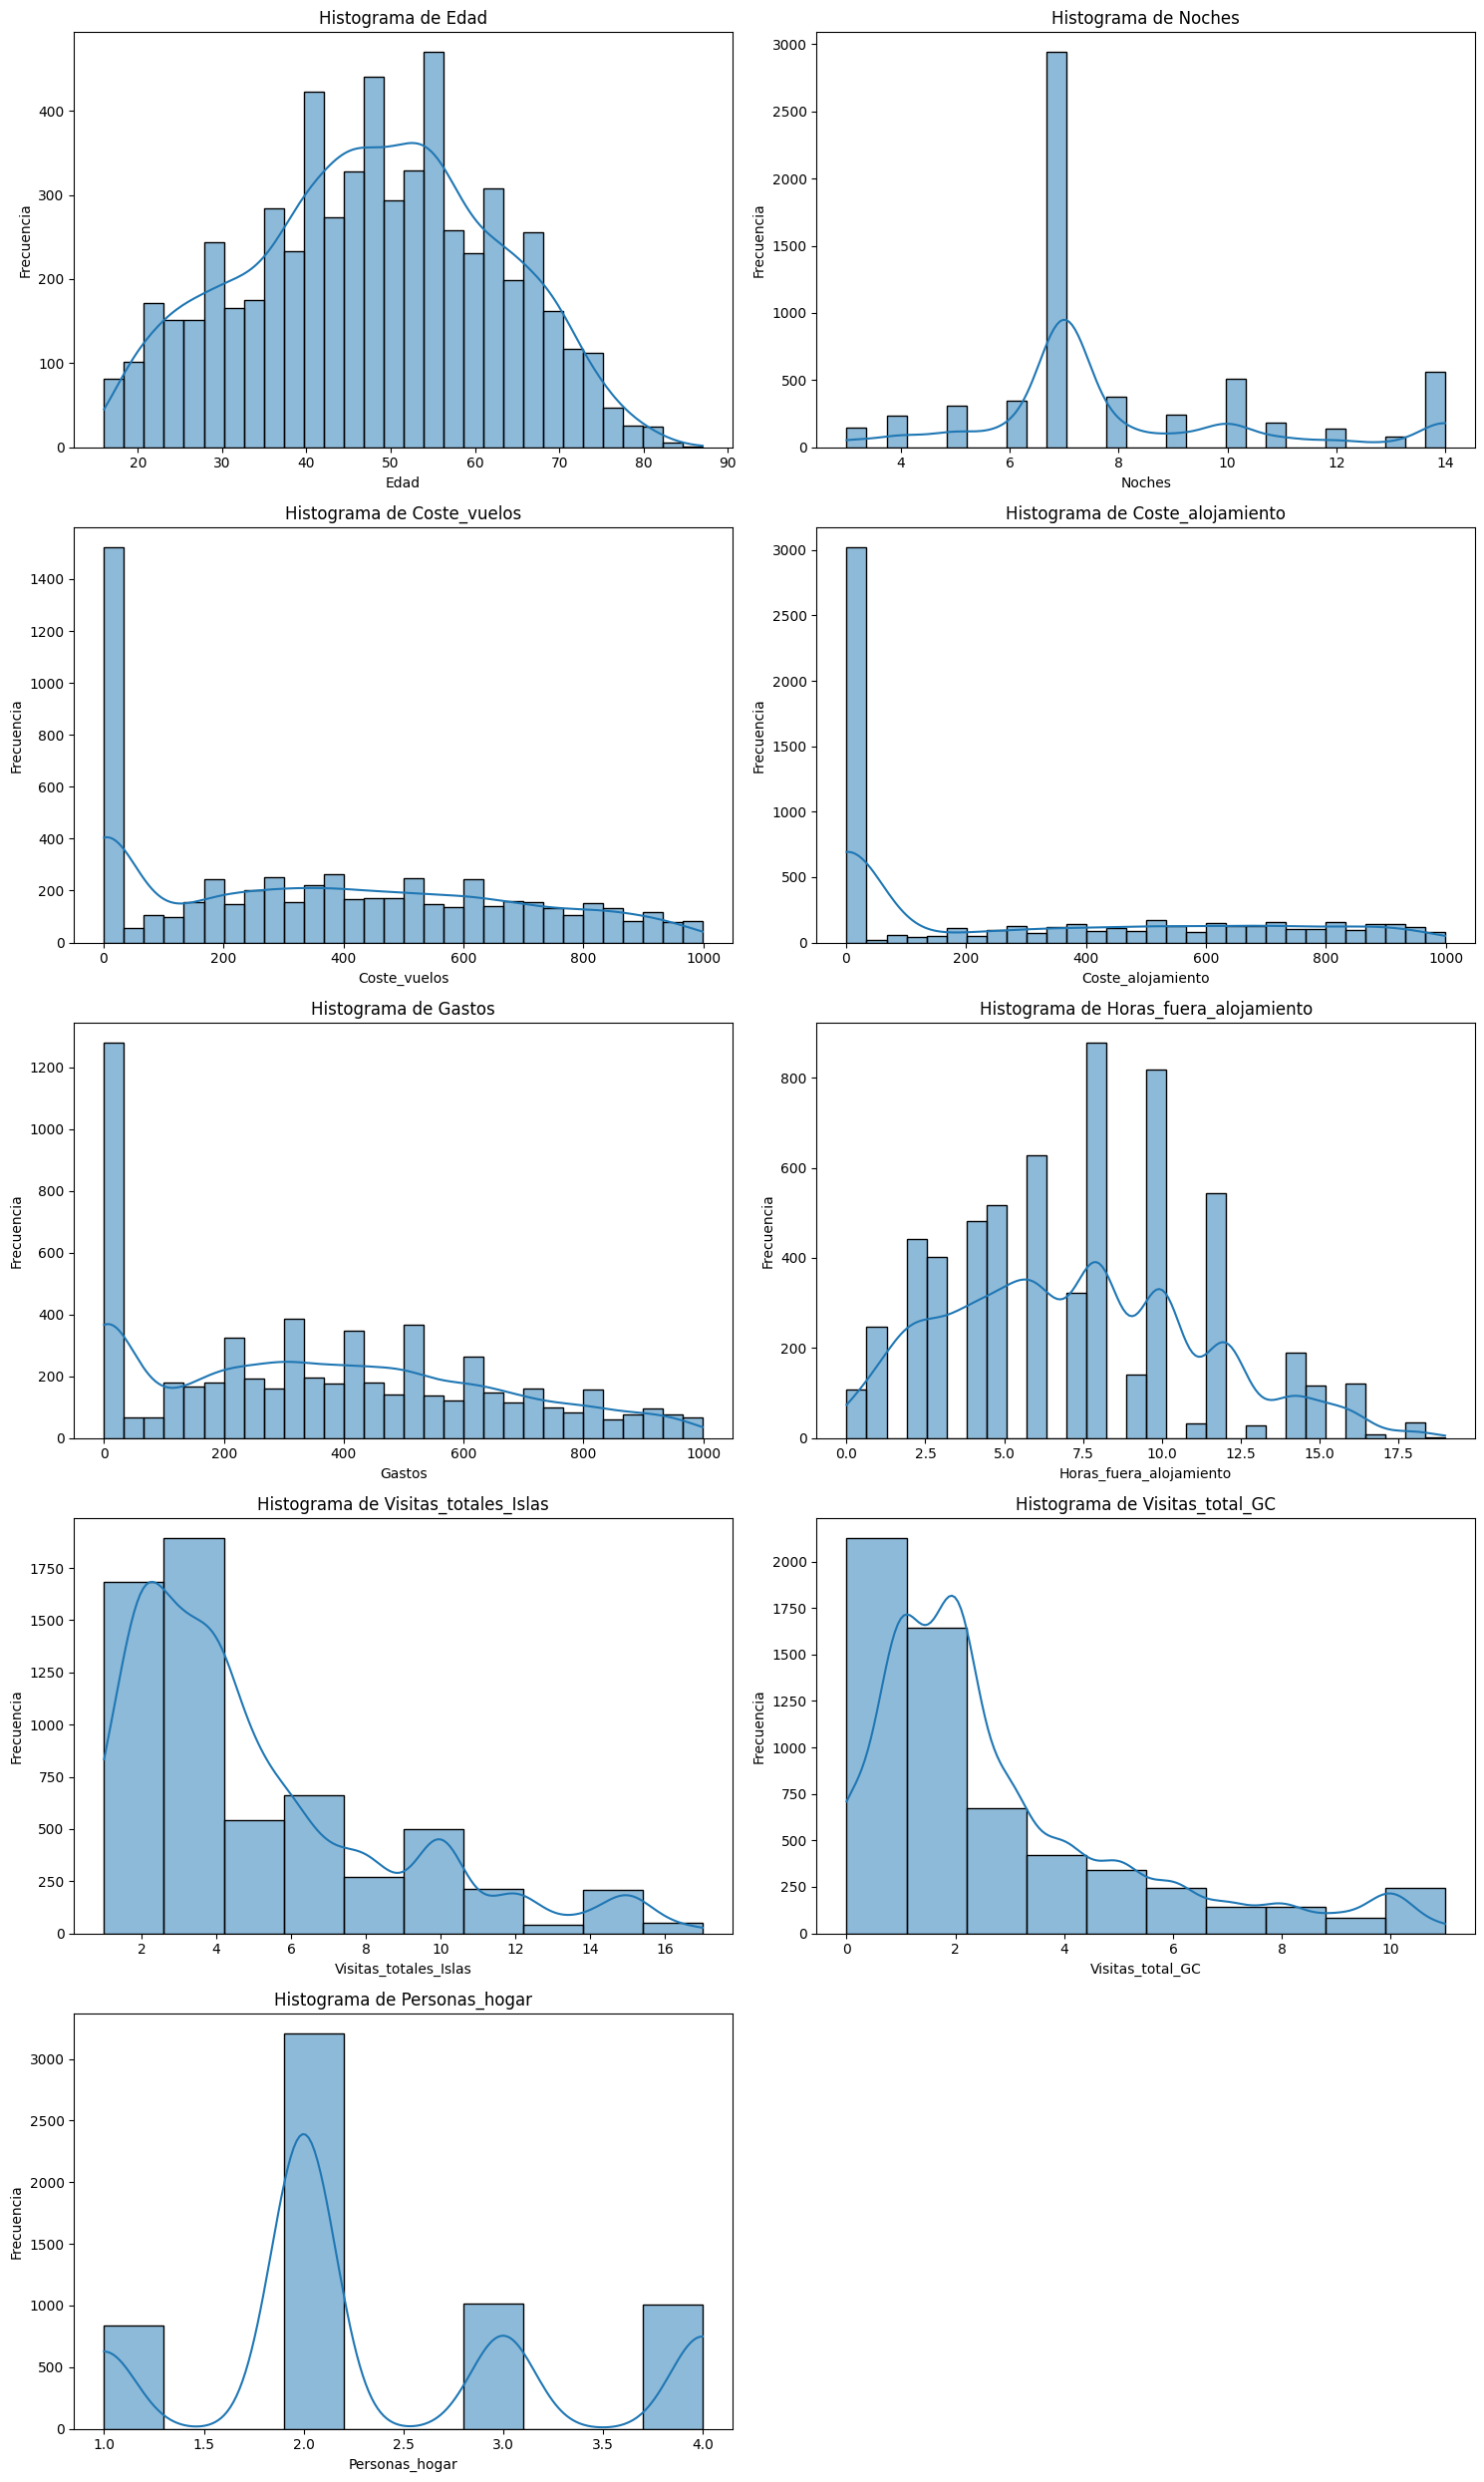

In [162]:
funciones.plot_numerical_histograms(df_2019, variables_numericas, bins_list=[30,30,30,30,30,30], kde=True)

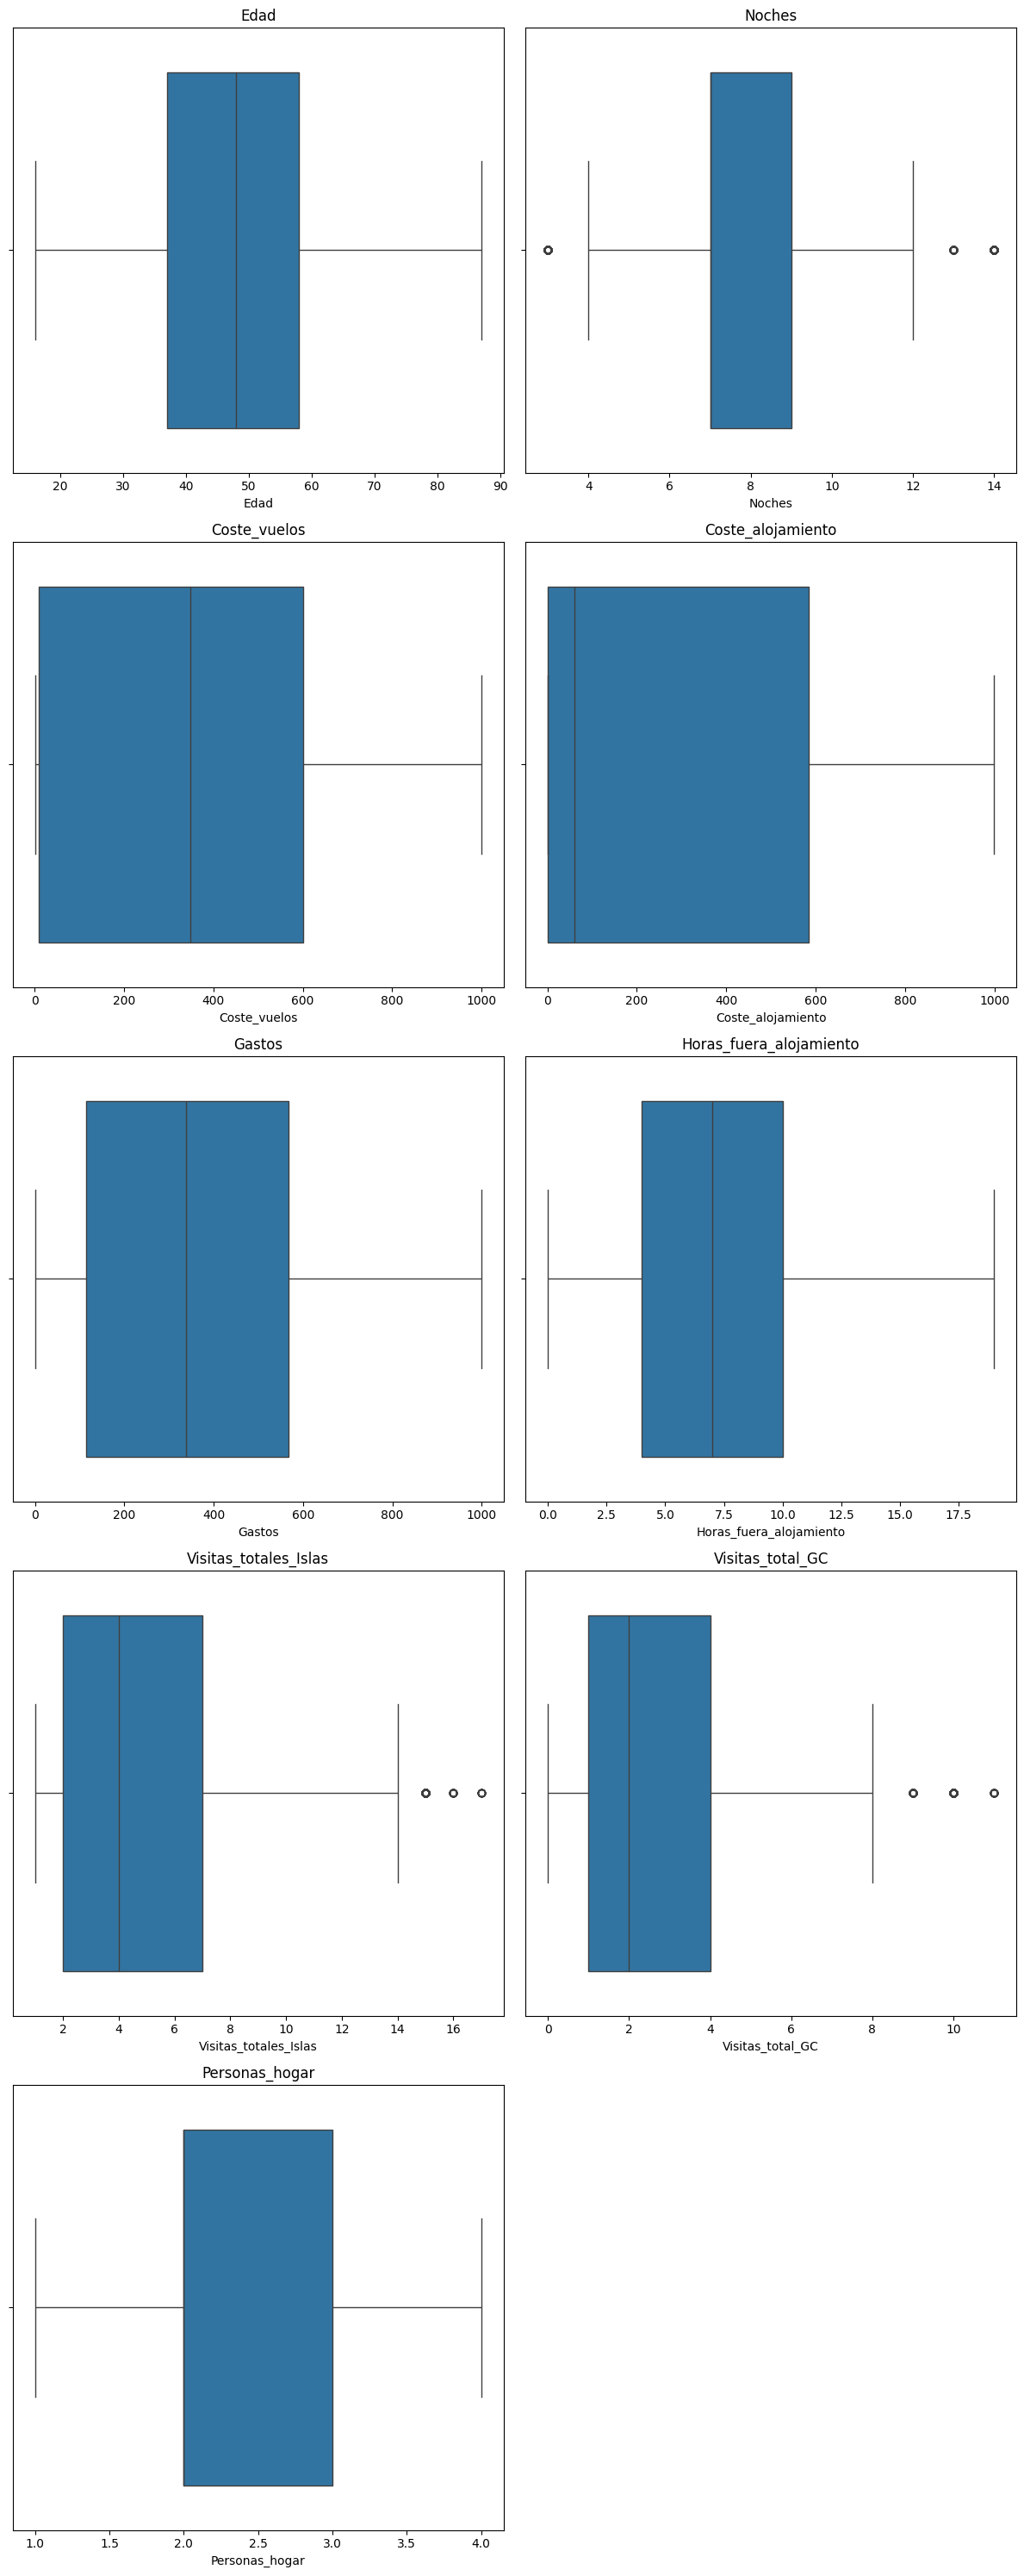

In [163]:
funciones.plot_multiple_boxplots(df_2019, variables_numericas)

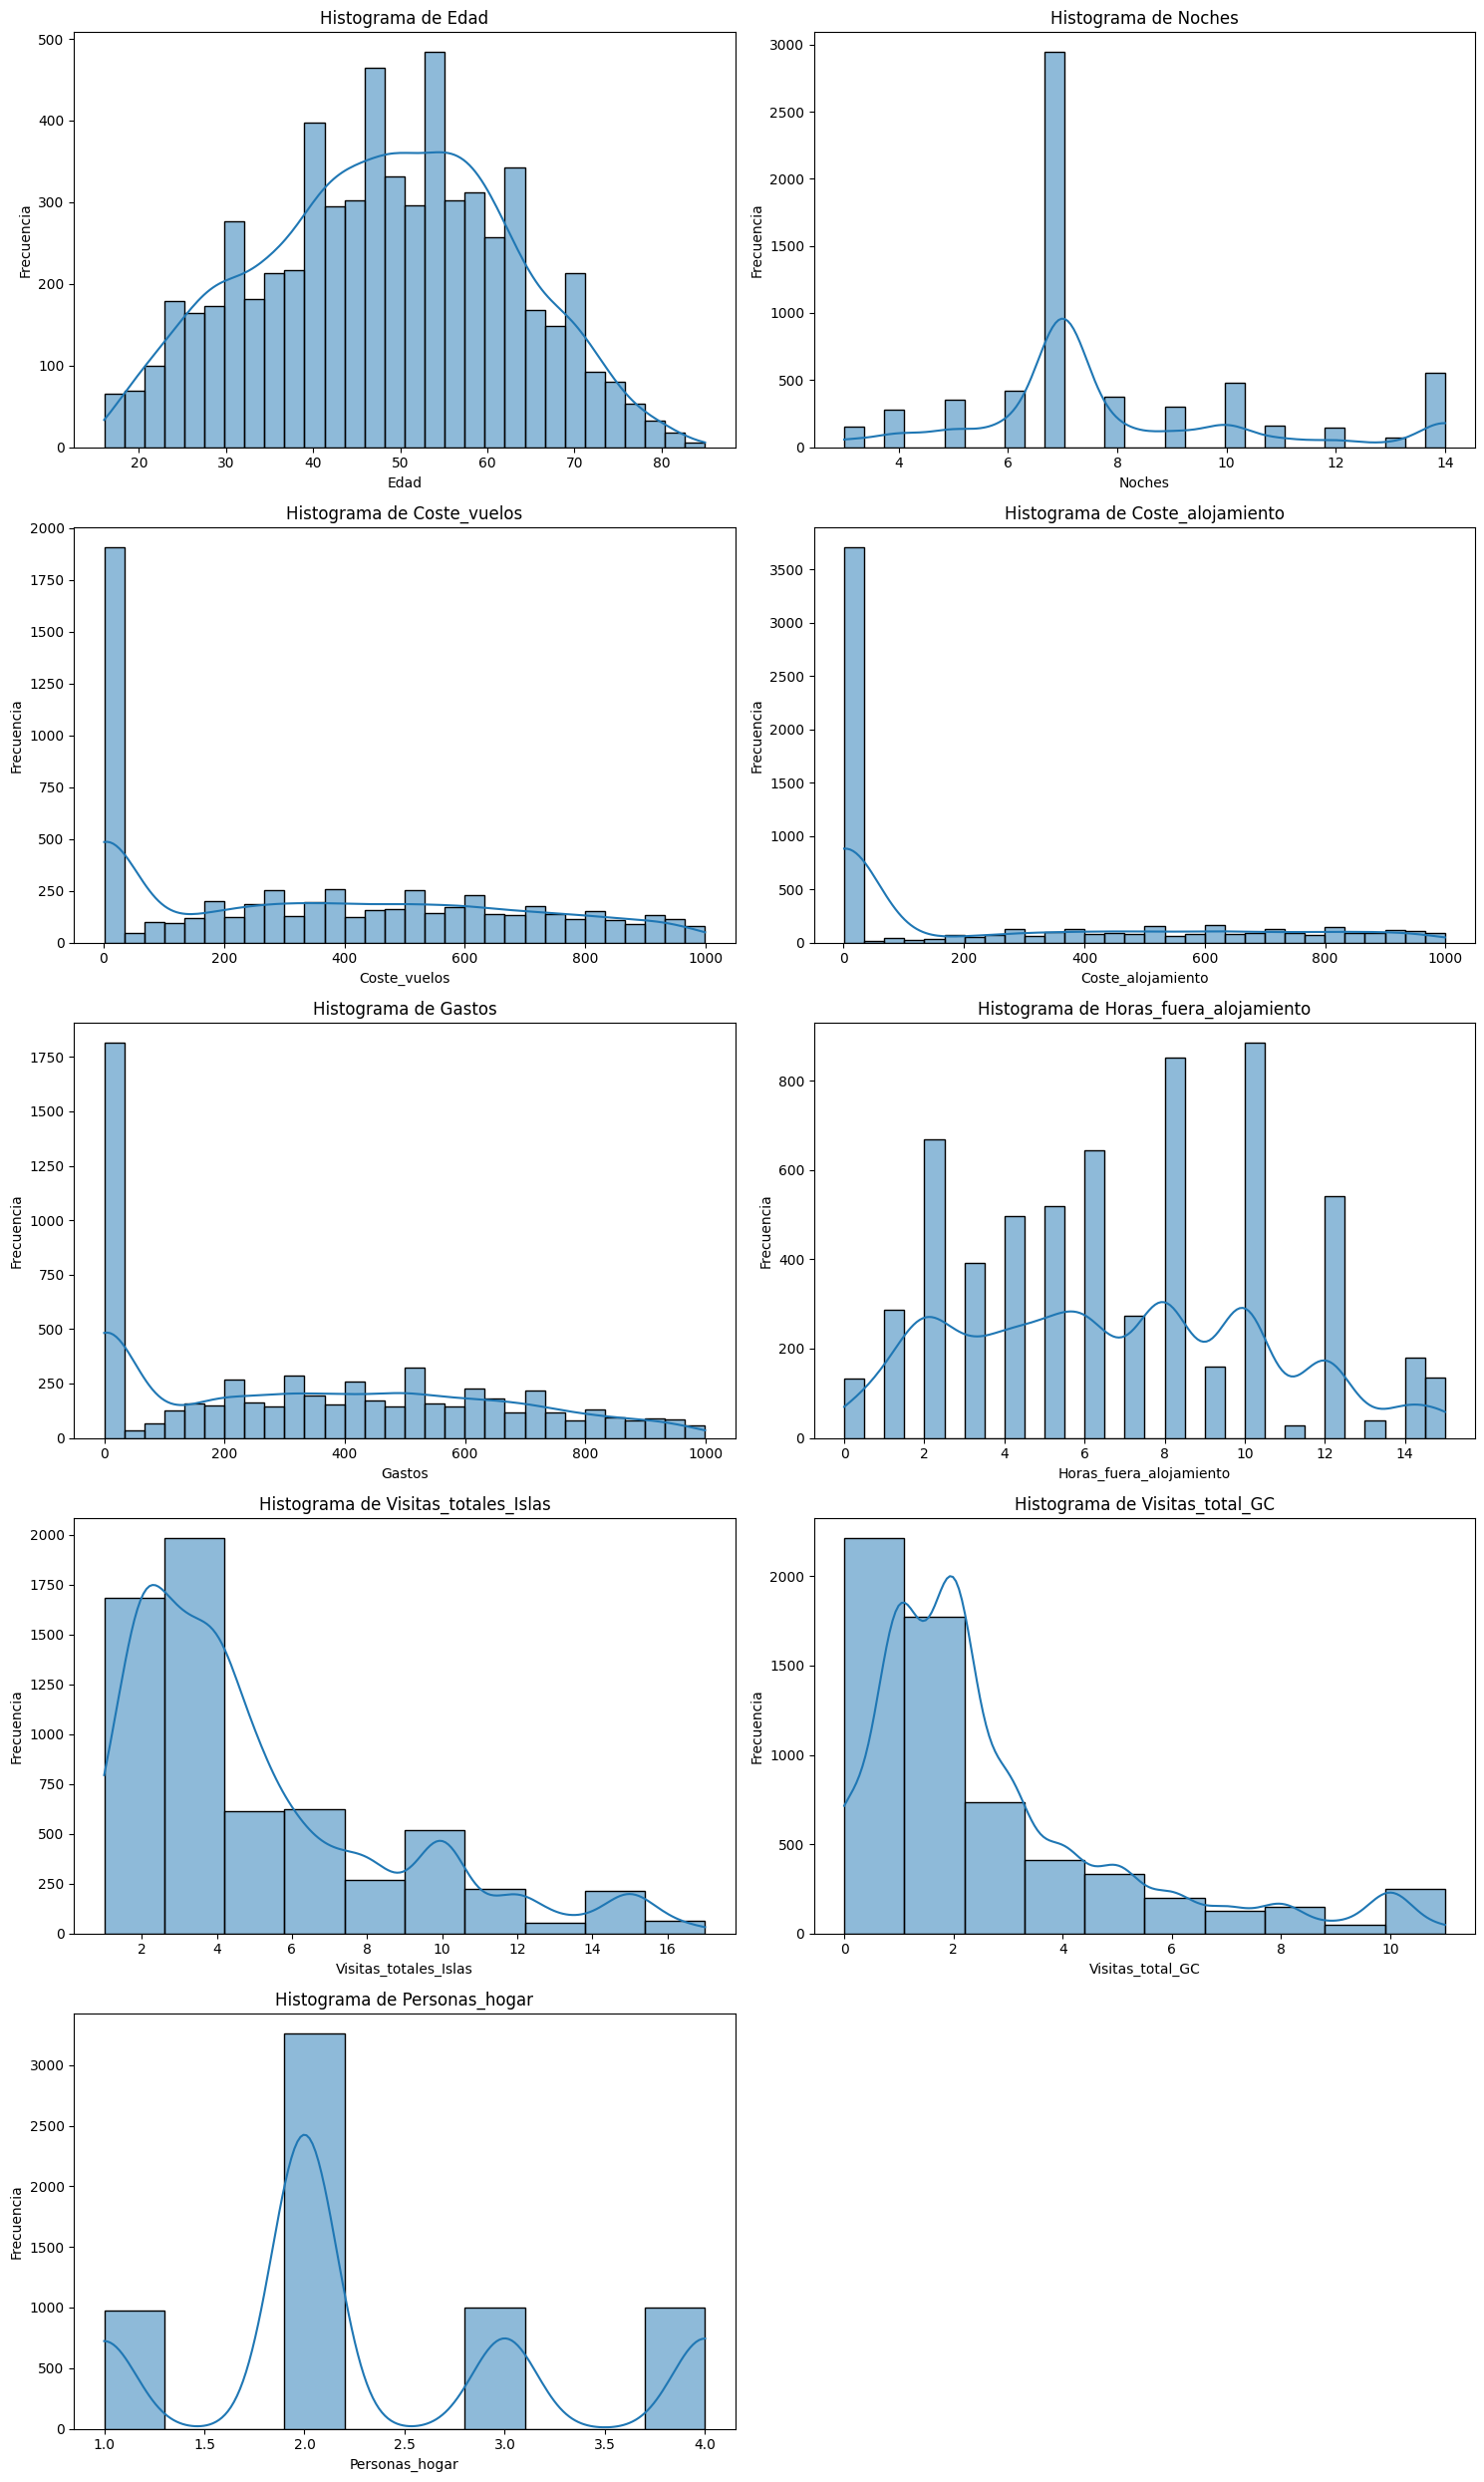

In [164]:
funciones.plot_numerical_histograms(df_2022, variables_numericas, bins_list=[30,30,30,30,30,30], kde=True)

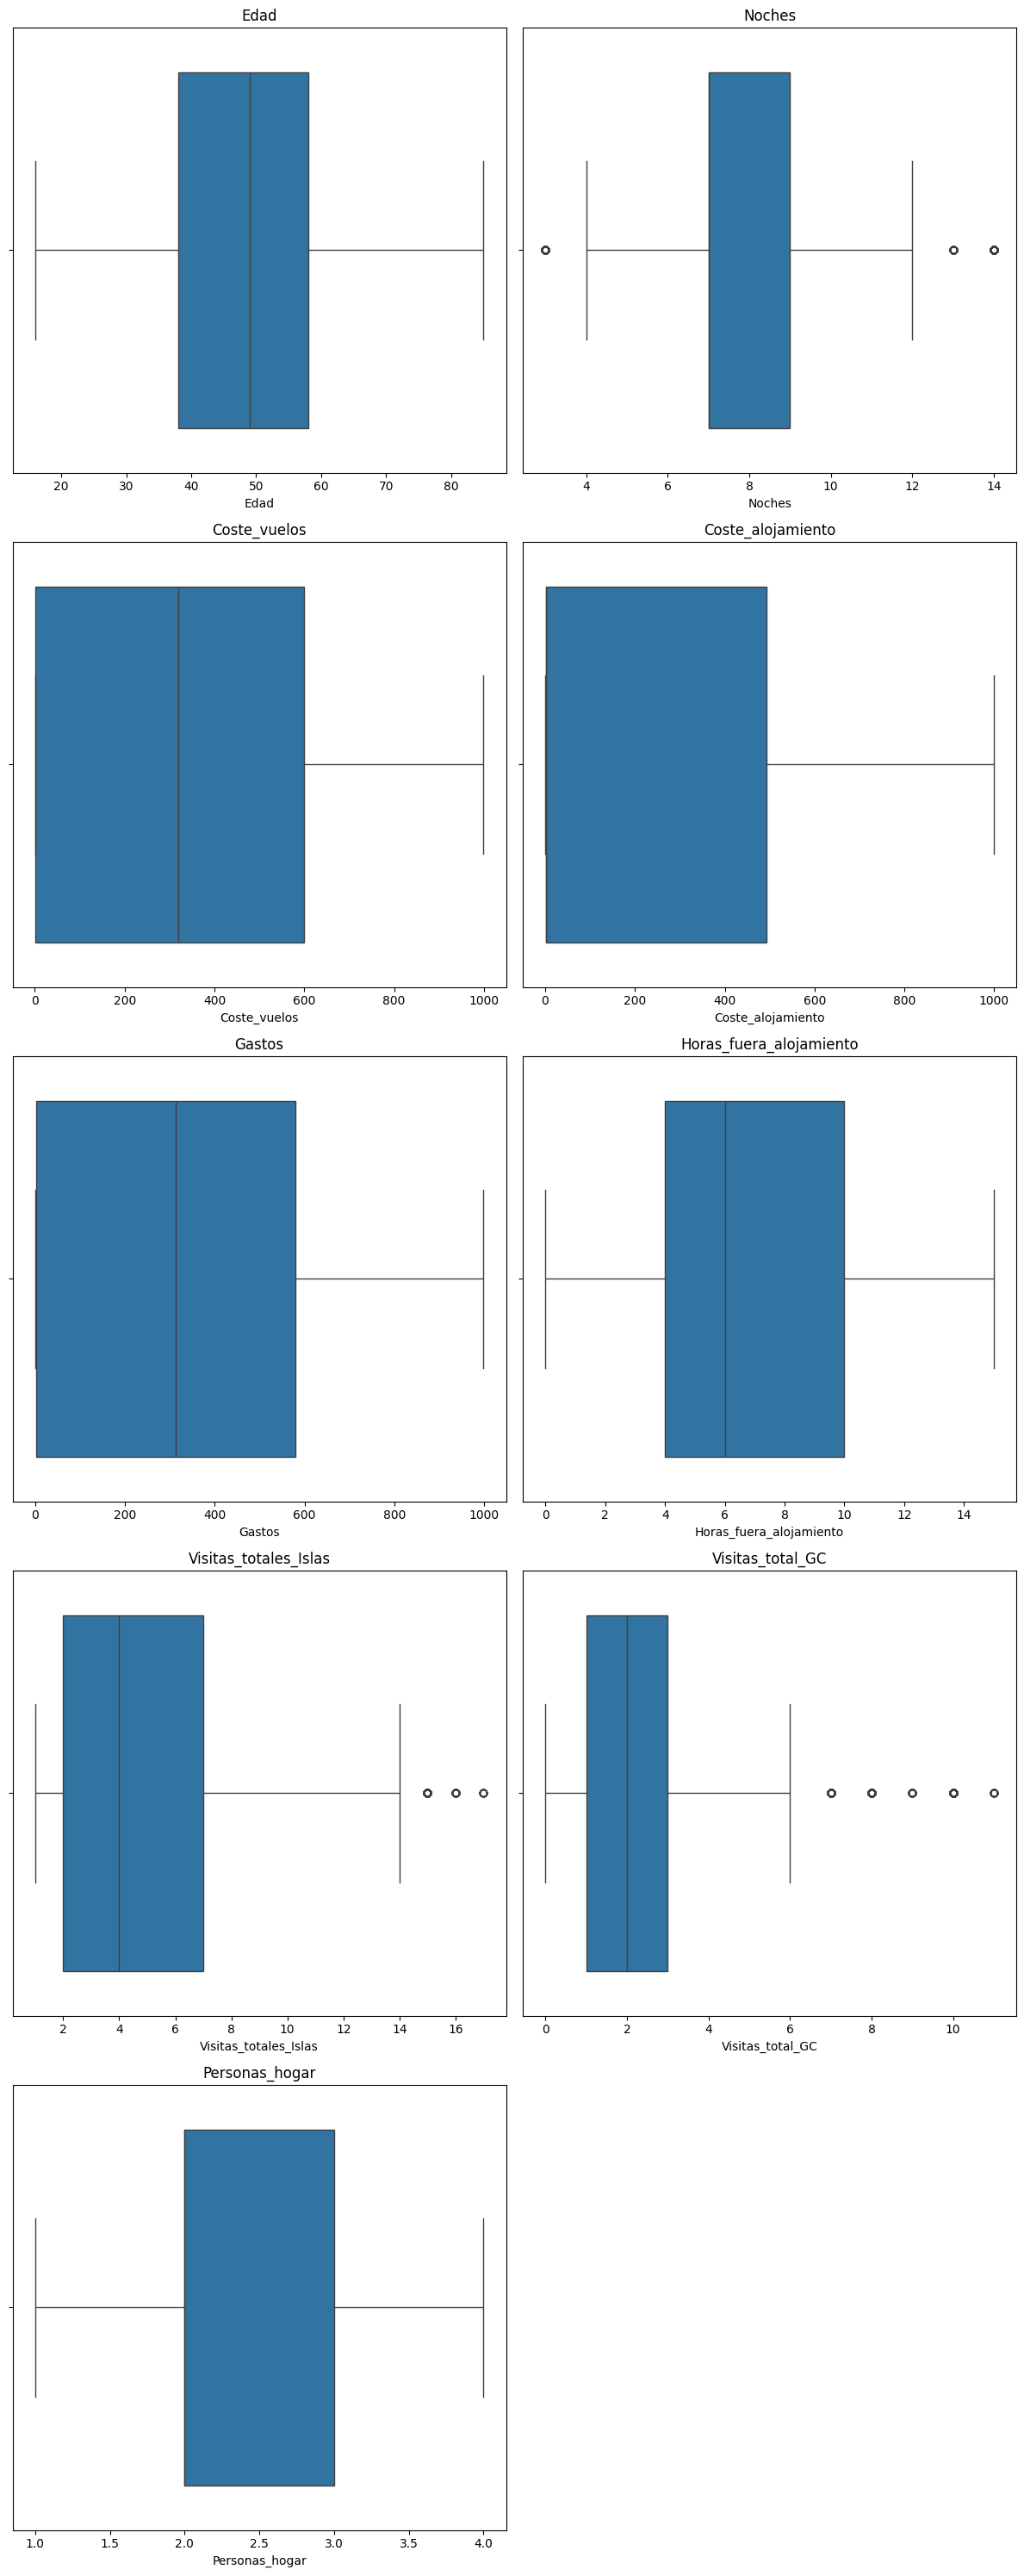

In [165]:
funciones.plot_multiple_boxplots(df_2022, variables_numericas)

Veamos 2022 en profundidad

In [166]:
funciones.variabilidad(df_perfil_turistico)

std         mean        CV
Edad                      14.437511    47.902643  0.301393
Noches                     2.650466     7.927288  0.334347
Coste_vuelos             304.706450   358.823633  0.849182
Coste_alojamiento        329.849914   260.910635  1.264226
Gastos                   287.236100   350.865951  0.818649
Horas_fuera_alojamiento    3.867095     6.983489  0.553748
Visitas_totales_Islas      3.576408     5.043432  0.709122
Visitas_total_GC           2.467661     2.758764  0.894481
Personas_hogar             0.919770     2.342416  0.392659
Año                        1.499913  2020.521106  0.000742

- Alta dispersión: Las variables como "Coste de los vuelos", "Coste de alojamiento", "Gastos" y "Visitas totales GC" tienen un coeficiente de variación alto, lo que indica que hay una gran dispersión en torno a la media, es decir, valores extremos o muy diferentes.
- Baja dispersión: Variables como "Edad", "Horas fuera de alojamiento", y "Personas en el hogar" tienen un coeficiente de variación más bajo, lo que indica que los datos son más homogéneos.
- Año: La variable "Año" tiene una dispersión casi nula, sugiriendo que todos los datos provienen del mismo período (probablemente 2020).

In [167]:
# Filtrar los datos según tipo de alojamiento
alojamiento_privado = df_2022[df_2022['Tipo_alojamiento'] == 'Alojamiento privado']['Coste_alojamiento']
alojamiento_rural = df_2022[df_2022['Tipo_alojamiento'] == 'Alojamiento rural']['Coste_alojamiento']
apartamento_villa = df_2022[df_2022['Tipo_alojamiento'] == 'Apartamento/Villa']['Coste_alojamiento']
hotel_1_2_3 = df_2022[df_2022['Tipo_alojamiento'] == 'Hotel 1-2-3*']['Coste_alojamiento']
hotel_4 = df_2022[df_2022['Tipo_alojamiento'] == 'Hotel 4*']['Coste_alojamiento']
hotel_5 = df_2022[df_2022['Tipo_alojamiento'] == 'Hotel 5*']['Coste_alojamiento']
vivienda_airbnb = df_2022[df_2022['Tipo_alojamiento'] == 'Vivienda/airbnb']['Coste_alojamiento']

# Realizar el análisis de varianza (ANOVA)
f_statistic, p_value = f_oneway(
    alojamiento_privado, alojamiento_rural, apartamento_villa, 
    hotel_1_2_3, hotel_4, hotel_5, vivienda_airbnb
)

# Mostrar los resultados
print(f"Estadística F: {f_statistic}, P-value: {p_value}")

Estadística F: 48.03596228096282, P-value: 6.359282481677296e-58


Dado que el valor p es mucho menor que 0.05, podemos concluir que sí existen diferencias significativas en los costes de alojamiento entre al menos dos de los tipos de alojamiento que has analizado. Esto sugiere que los diferentes tipos de alojamiento tienen costes de alojamiento muy diferentes.

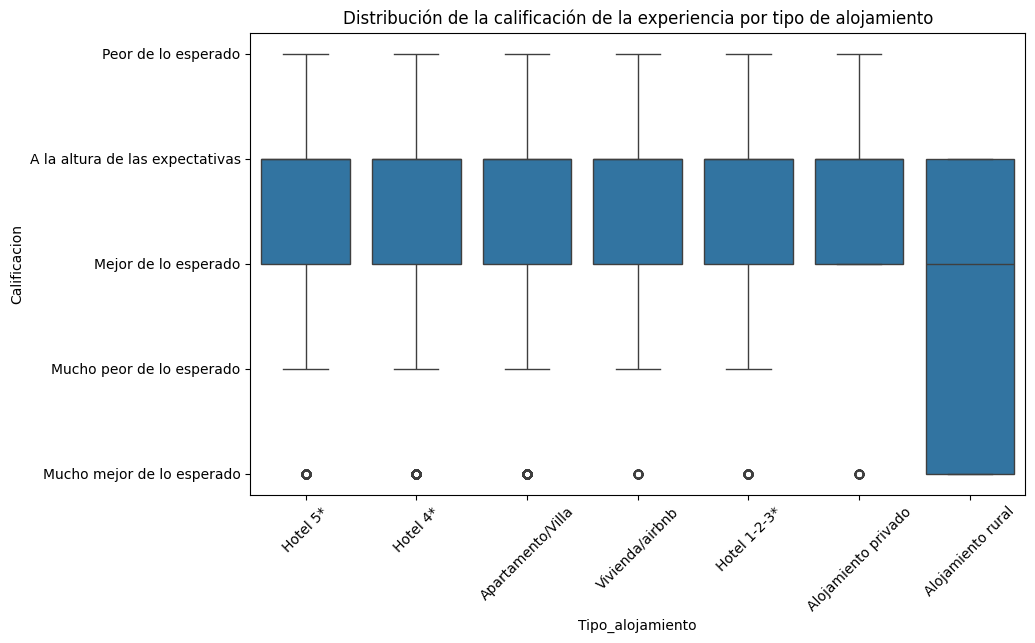

In [168]:
funciones.plot_calificacion_por_alojamiento(df_2022)

Aquí se observa claramente que la valoración a los alojamientos rurales es negativa con respecto al resto de alojamientos que se mantienen en valoraciones más positivas

In [169]:
# Filtrar las categorías de hoteles
hoteles_2019 = df_2019[df_2019['Tipo_alojamiento'].isin(['Hotel 1-2-3*', 'Hotel 4*', 'Hotel 5*'])]
hoteles_2022 = df_2022[df_2022['Tipo_alojamiento'].isin(['Hotel 1-2-3*', 'Hotel 4*', 'Hotel 5*'])]

# Calcular métricas clave
perfil_hotelero_2019 = {
    'Año': 2019,
    'Total_Turistas': len(hoteles_2019),
    'Duracion_Promedio': hoteles_2019['Noches'].mean(),
    'Gasto_Total_Promedio': (hoteles_2019['Coste_vuelos'] + hoteles_2019['Coste_alojamiento'] + hoteles_2019['Gastos']).mean(),
    'Edad_Promedio': hoteles_2019['Edad'].mean(),
    'Nacionalidad_Principal': hoteles_2019['Nacionalidad'].mode()[0],
    'Horas_fuera_promedio': hoteles_2019['Horas_fuera_alojamiento'].mean()
}

perfil_hotelero_2022 = {
    'Año': 2022,
    'Total_Turistas': len(hoteles_2022),
    'Duracion_Promedio': hoteles_2022['Noches'].mean(),
    'Gasto_Total_Promedio': (hoteles_2022['Coste_vuelos'] + hoteles_2022['Coste_alojamiento'] + hoteles_2022['Gastos']).mean(),
    'Edad_Promedio': hoteles_2022['Edad'].mean(),
    'Nacionalidad_Principal': hoteles_2022['Nacionalidad'].mode()[0],
    'Horas_fuera_promedio': hoteles_2022['Horas_fuera_alojamiento'].mean()
}

# Crear un DataFrame con los resultados
perfil_hotelero_df = pd.DataFrame([perfil_hotelero_2019, perfil_hotelero_2022])
print(perfil_hotelero_df)

    Año  Total_Turistas  Duracion_Promedio  Gasto_Total_Promedio  \
0  2019            3674           7.910452            980.422476   
1  2022            3957           7.869093            900.475600   

   Edad_Promedio Nacionalidad_Principal  Horas_fuera_promedio  
0      47.903919               Alemania              6.443658  
1      48.296689                 España              6.151630  


>Perfil hotelero del turista promedio por años:

|Año|Total_Turistas|Noches_Promedio|Gasto_Total_Promedio|Edad_Promedio| Nacionalidad_Principal|Horas_fuera_promedio|
|-|-|-|-|-|-|-|
|2019|3.674|7.91|980€|48|Alemania|7|
|2022|3.957|7.86|900€|48|España|6| 

# ***3. Análisis bivariantes***

Es momento de analizar si existe alguna relación entre las variables de nuestro dataset. 

Estas relaciones pueden adoptar diferentes formas:

- Independencia: cuando no hay relación entre las variables.
- Correlación: cuando las variables cambian de manera simultánea, aunque no necesariamente en la misma dirección o con una relación causal.
- Causalidad: cuando el cambio en una variable provoca un cambio en otra como consecuencia directa.

Dado el gran número de variables analizadas, el [estudio bivariante](notebooks/notebooks_EDA_anailisis_bivariante.ipynb) se ha llevado a cabo en un notebook independiente.

A continuación, presentamos los principales resultados que responden a las hipótesis planteadas en este análisis

1. Duración promedio por nacionalidad

In [170]:
#Primero veamos si existe o no realción entre ambas variables
tabla_contingencia_nacionalidad = pd.crosstab(df_2022['Noches'], df_2022['Nacionalidad'])
chi2, p, dof, expected = chi2_contingency(tabla_contingencia_nacionalidad)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
#print("Tabla de Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 1514.766087498414
P-Value: 1.2693171367299605e-227
Grados de Libertad: 143


Este es un valor muy alto, lo que indica una gran discrepancia entre las frecuencias observadas y las esperadas bajo la hipótesis de independencia.
Esto sugiere que podría haber una relación significativa entre las variables.
Un valor p tan bajo indica que rechazamos la hipótesis nula. Esto significa que existe una relación significativa entre las Noches y la Nacionalidad
Grados de Libertad: 143
Un número alto de grados de libertad refleja que estamos analizando una tabla con muchas combinaciones posibles entre las categorías de ambas variables.

2019

    Nacionalidad  Duracion_Promedio_2019
0       Alemania                8.950606
8        Noruega                8.864929
12        Suecia                8.340000
10  Paises Bajos                8.333333
13         Suiza                8.202555
11   Reino Unido                8.000000
4      Finlandia                7.951327
2      Dinamarca                7.934884
9          Otros                7.846482
5        Francia                7.728395


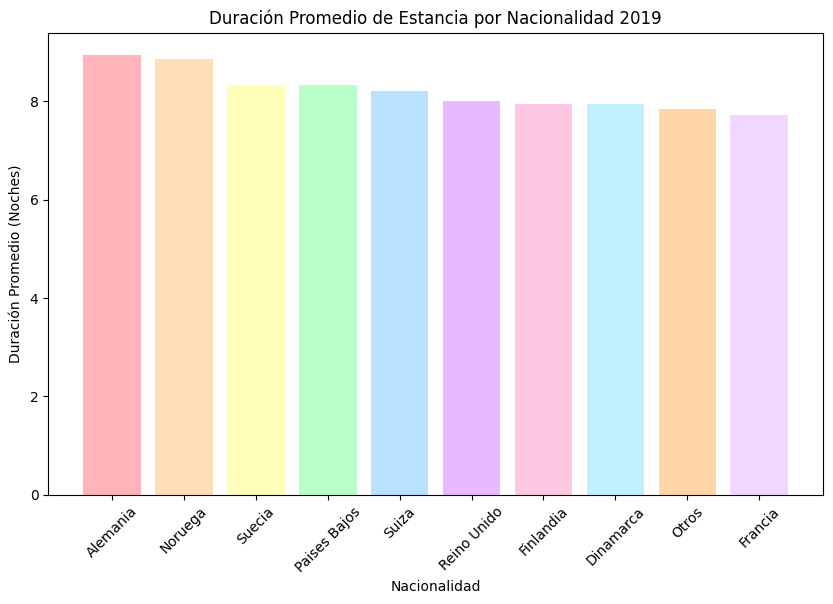

In [171]:
#Calculamos la duración promedio por nacionalidad mostrando las 10 nacionalidades con mayor duración
duracion_promedio_2019 = df_2019.groupby('Nacionalidad')['Noches'].mean().reset_index()
duracion_promedio_2019 = duracion_promedio_2019.rename(columns={'Noches': 'Duracion_Promedio_2019'})
duracion_promedio_2019 = duracion_promedio_2019.sort_values(by='Duracion_Promedio_2019', ascending=False)
# Mostrar los primeros resultados
print(duracion_promedio_2019.head(10))
funciones.plot_duracion_promedio_por_nacionalidad_2019(duracion_promedio_2019)

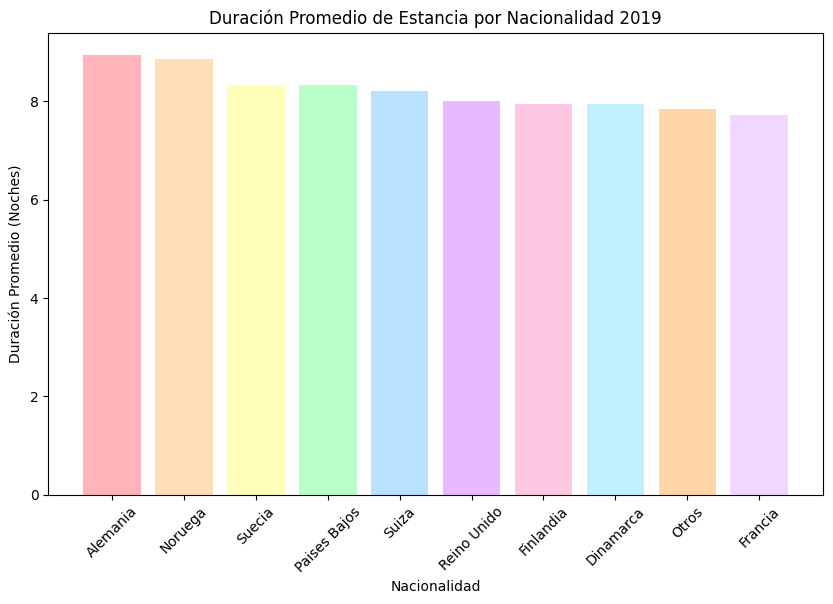

In [172]:
funciones.plot_duracion_promedio_por_nacionalidad_2019(duracion_promedio_2019)

2022

    Nacionalidad  Duracion_Promedio_2022
0       Alemania                8.851781
12        Suecia                8.500000
8        Noruega                8.471744
10  Paises Bajos                8.308571
4      Finlandia                8.280952
13         Suiza                8.253036
2      Dinamarca                8.098131
11   Reino Unido                7.962963
9          Otros                7.831810
1        Bélgica                7.798851


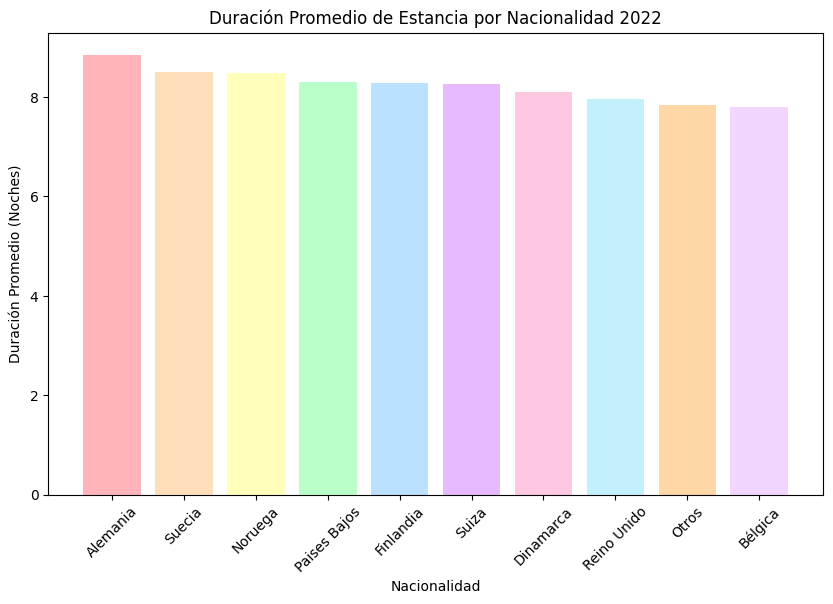

In [173]:
#Calculamos la duración promedio por nacionalidad mostrando las 10 nacionalidades con mayor duración
duracion_promedio_2022 = df_2022.groupby('Nacionalidad')['Noches'].mean().reset_index()
duracion_promedio_2022 = duracion_promedio_2022.rename(columns={'Noches': 'Duracion_Promedio_2022'})
duracion_promedio_2022 = duracion_promedio_2022.sort_values(by='Duracion_Promedio_2022', ascending=False)
# Mostrar los primeros resultados
print(duracion_promedio_2022.head(10))
funciones.plot_duracion_promedio_por_nacionalidad_2022(duracion_promedio_2022)

Se muestra un cambio de comportamiento en los turistas de Suecia, Reiuno Unido y Francia. 

Veamos el comportamiento del turista según el cuatrimestres:

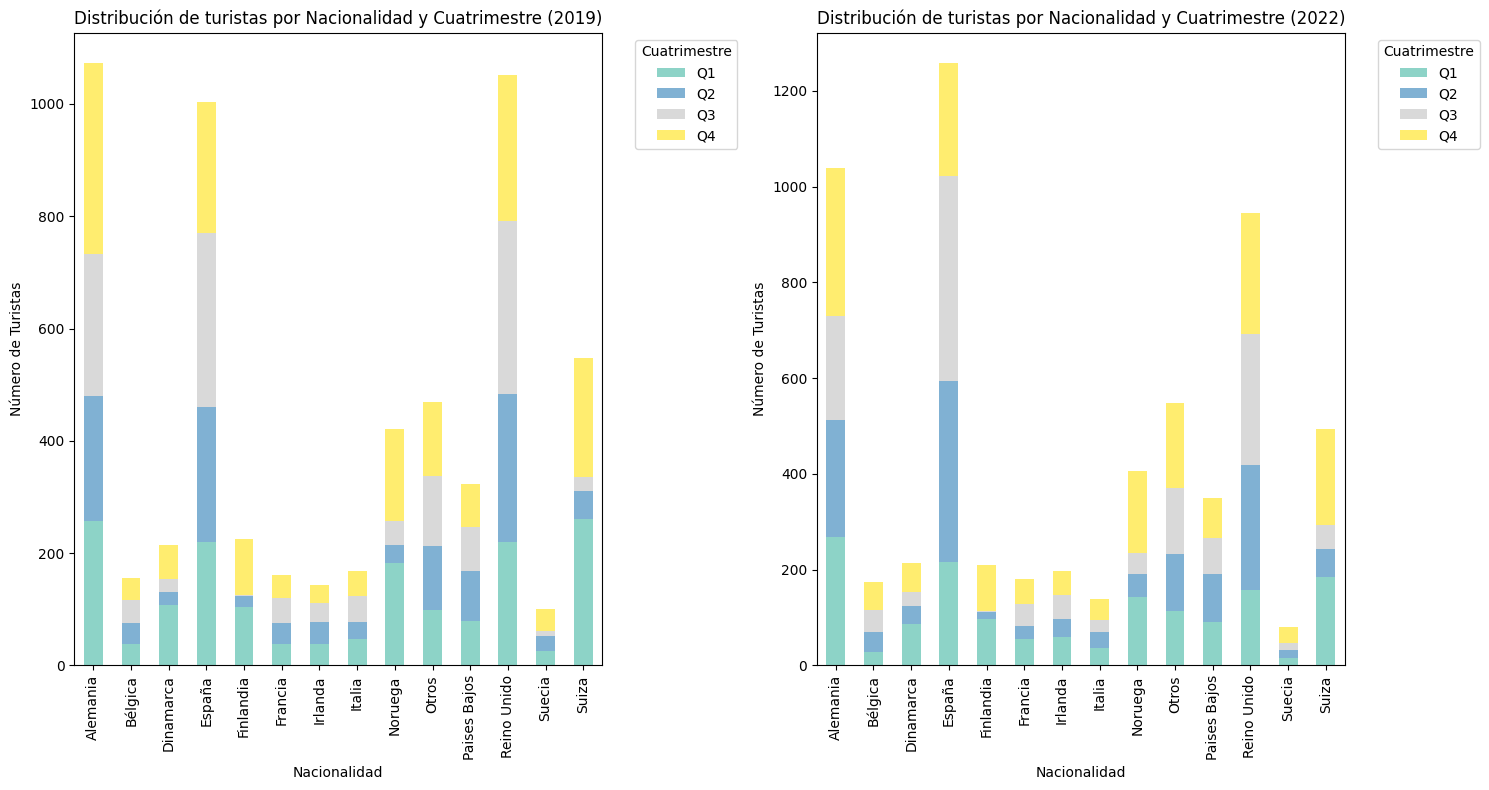

In [174]:
# Contar turistas por nacionalidad y cuatrimestre para 2019
viaje_2019 = df_2019.groupby(['Nacionalidad', 'Cuatrimestre']).size().unstack(fill_value=0)

# Contar turistas por nacionalidad y cuatrimestre para 2022
viaje_2022 = df_2022.groupby(['Nacionalidad', 'Cuatrimestre']).size().unstack(fill_value=0)

funciones.graficar_turistas_por_nacionalidad_y_cuatrimestre(viaje_2019, viaje_2022)

Se muestra como el pérfil de los paises con frío frecuentan en su mayoría GC los Q1-Q4 que son los meses más frios en su país mientras que otros pasies como España, Reino Unido y otros frecuentas las islas en los meses de verano (Q3)

2. Número de turistas por año

    Año  Total_Turistas
0  2019            6061
1  2022            6234


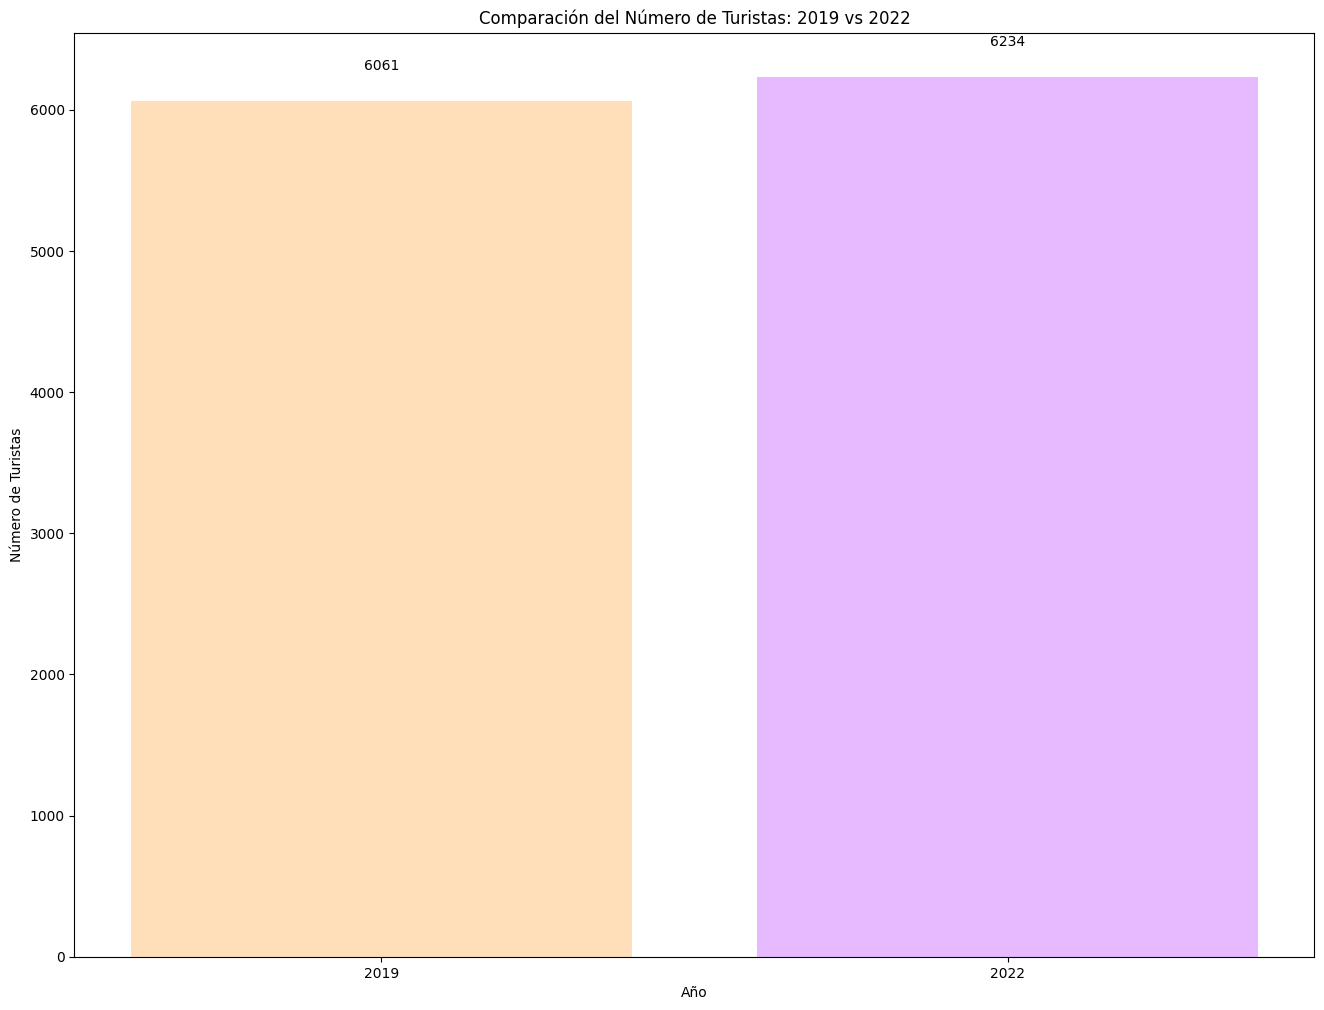

In [190]:
# Calcular el número total de turistas en cada año
total_turistas_2019 = len(df_2019)
total_turistas_2022 = len(df_2022)
# Crear un DataFrame con los resultados
data_comparacion = pd.DataFrame({
    'Año': ['2019', '2022'],
    'Total_Turistas': [total_turistas_2019, total_turistas_2022]
})

# Mostrar los resultados numéricos
print(data_comparacion)
funciones.plot_comparacion_turistas_year(data_comparacion)


Pese a la pandemia, el número de turistas que visitó GC aumentó, gracias a la presencia del mercado Español que mejoró los resultados esperados

3. Estacionalidad: Número de turistas y duración promedio por cuatrimestre

Número de turistas por cuatrimestre y año:
Cuatrimestre    Q1    Q2    Q3    Q4
Año                                 
2019          1721  1223  1338  1779
2022          1554  1417  1439  1824

Duración promedio de la estancia por cuatrimestre y año:
Cuatrimestre        Q1        Q2        Q3        Q4
Año                                                 
2019          7.701336  7.828291  8.522422  7.931422
2022          7.840412  7.713479  8.154969  7.826754


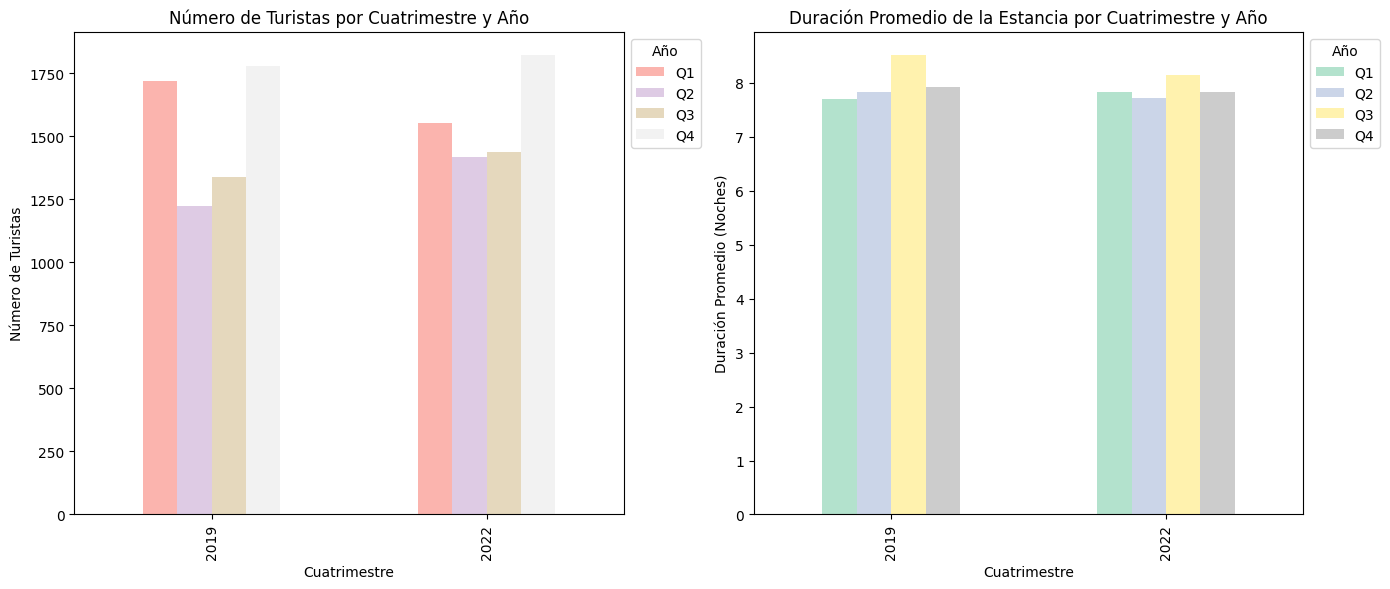

In [177]:
# Calcular el número de turistas por cuatrimestre y año
num_turistas_cuatrimestre_anio = df_perfil_turistico.groupby(['Año', 'Cuatrimestre']).size().unstack()

# Calcular la duración promedio por cuatrimestre y año
duracion_promedio_cuatrimestre_anio = df_perfil_turistico.groupby(['Año', 'Cuatrimestre'])['Noches'].mean().unstack()

# Mostrar los resultados numéricos
print("Número de turistas por cuatrimestre y año:")
print(num_turistas_cuatrimestre_anio)

print("\nDuración promedio de la estancia por cuatrimestre y año:")
print(duracion_promedio_cuatrimestre_anio)
#Gráfico
funciones.plot_turistas_y_duracion_por_cuatrimestre(num_turistas_cuatrimestre_anio, duracion_promedio_cuatrimestre_anio)

En la primera gráfica se observa que en 2019 los turistas tenían como preferencia viajar en Q1 y Q3 mientras que en 2022 hay mayor número de turistas en el Q1 y Q4.

Sin embargo, desde el punto de vista de noches promedio, el comportamiento es similar en ambos años.

4. Preferencias: Tipo de alojamiento por cuatrimestre

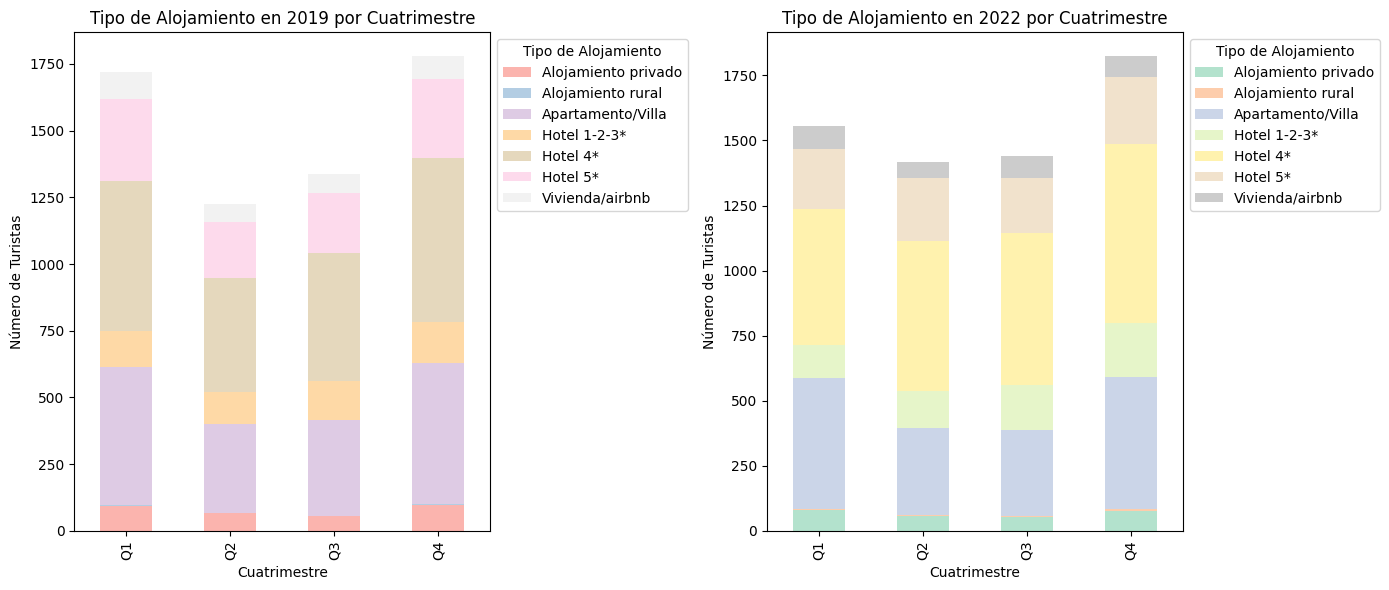

In [178]:
# Calcular la distribución del tipo de alojamiento por cuatrimestre y año
preferencia_alojamiento_2019 = df_2019.groupby(['Cuatrimestre', 'Tipo_alojamiento']).size().unstack()
preferencia_alojamiento_2022 = df_2022.groupby(['Cuatrimestre', 'Tipo_alojamiento']).size().unstack()
#Gráfico
funciones.plot_tipo_alojamiento_por_cuatrimestre(preferencia_alojamiento_2019, preferencia_alojamiento_2022)


Se muestra que el comportamiento de elección del alojamiento no influye en el cuatrimestre de viaje, veamos con un estadístico si esta premisa es correcta

In [179]:
# Crear una tabla de contingencia para Tipo de Alojamiento y Cuatrimestre
tabla_contingencia_alojamiento_cuatrimestre = pd.crosstab(df_2022['Tipo_alojamiento'], df_2022['Cuatrimestre'])
# Realizar la prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia_alojamiento_cuatrimestre)

# Mostrar los resultados
print(f"Valor Chi-cuadrado: {chi2}")
print(f"P-valor: {p}")
print(f"Grados de libertad: {dof}")


Valor Chi-cuadrado: 73.81976185536146
P-valor: 1.0095786355582262e-08
Grados de libertad: 18


El p-valor es muy bajo, esto nos lleva a rechazar la hipótesis nula de independencia, por lo que las dos variables Tipo de Alojamiento y Cuatrimestre no están relacionadas.

5. Repetiría

<Figure size 1200x600 with 0 Axes>

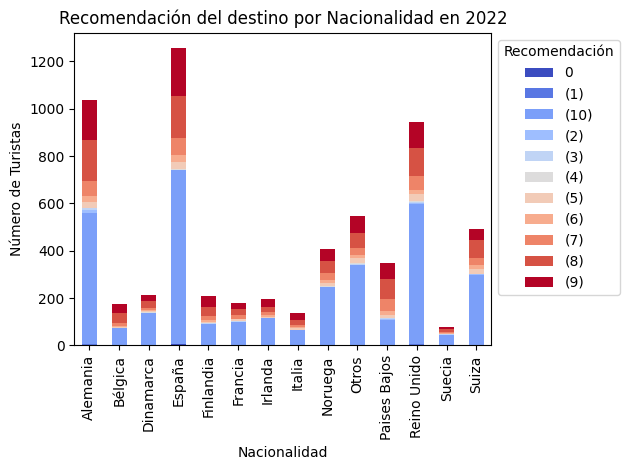

In [180]:
# Contar la recomendación (Repetiria) por nacionalidad
recomendacion_nacionalidad_2022 = df_2022.groupby(['Nacionalidad', 'Repetiria']).size().unstack().fillna(0)

#Gráfico
funciones.plot_recomendacion_por_nacionalidad(recomendacion_nacionalidad_2022)

Claramente se ve una alta calificación al destino indepientemente de la nacionalidad del turista.

6. Perfil socio-demográfico

<Figure size 1600x800 with 0 Axes>

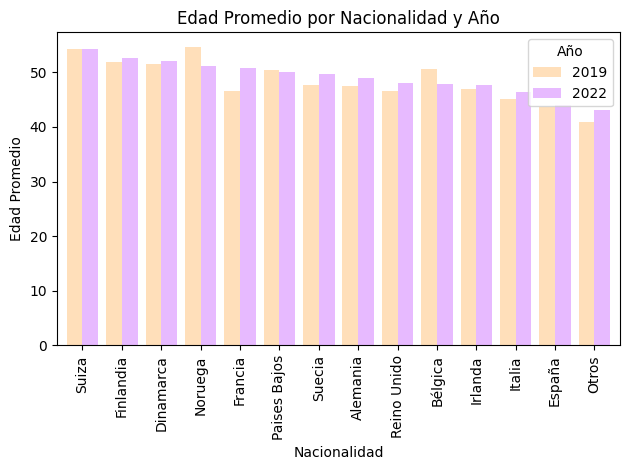

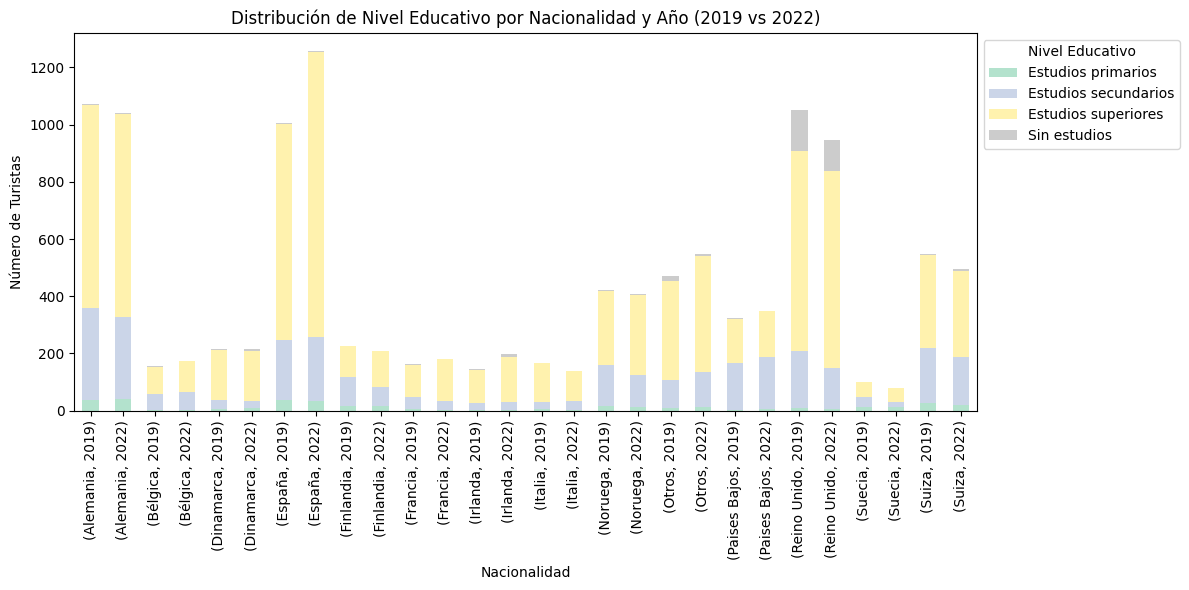

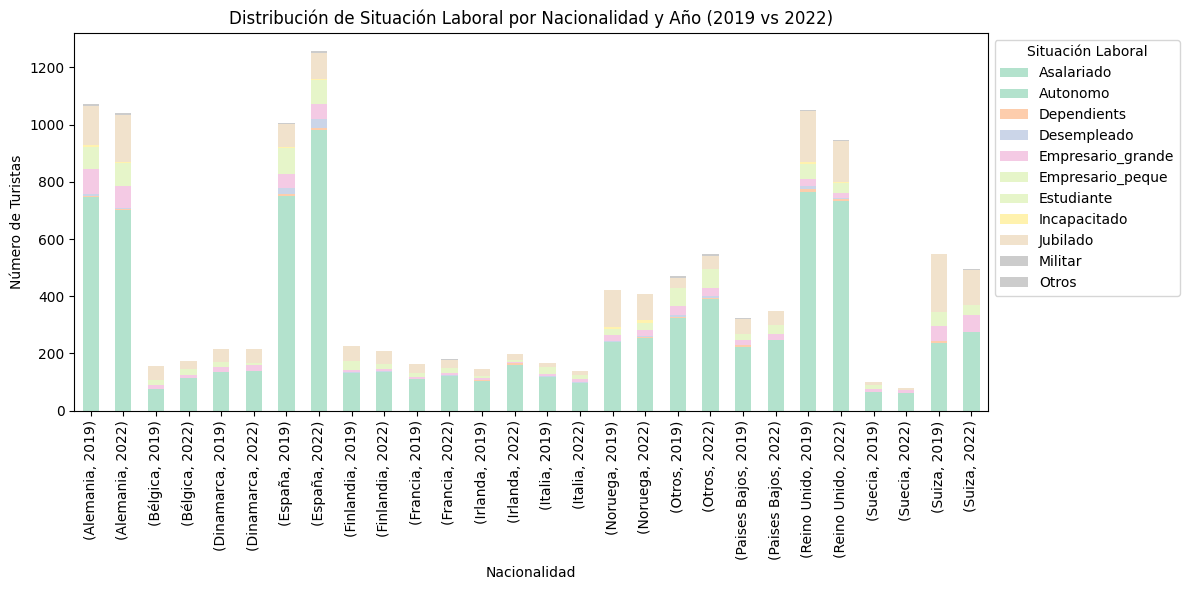

<Figure size 1200x600 with 0 Axes>

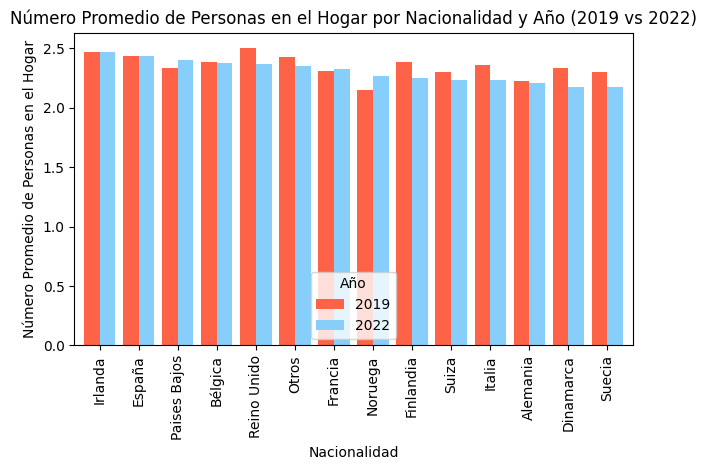

In [181]:
# Filtrar los datos para los años 2019 y 2022
df_2019_2022 = df_perfil_turistico[df_perfil_turistico['Año'].isin([2019, 2022])]

# 1. Edad promedio por nacionalidad y año
edad_promedio_nacionalidad_ano = df_2019_2022.groupby(['Nacionalidad', 'Año'])['Edad'].mean().unstack().sort_values(by=2022, ascending=False)

# 2. Distribución de nivel educativo por nacionalidad y año
educacion_nacionalidad_ano = df_2019_2022.groupby(['Nacionalidad', 'Año'])['Nivel_educativo'].value_counts().unstack().fillna(0)

# 3. Distribución de situación laboral por nacionalidad y año
laboral_nacionalidad_ano = df_2019_2022.groupby(['Nacionalidad', 'Año'])['Situacion_laboral'].value_counts().unstack().fillna(0)

# 4. Distribución de ingresos por nacionalidad y año
ingresos_nacionalidad_ano = df_2019_2022.groupby(['Nacionalidad', 'Año'])['Ingresos'].value_counts().unstack().fillna(0)

# 5. Número promedio de personas en el hogar por nacionalidad y año
personas_hogar_nacionalidad_ano = df_2019_2022.groupby(['Nacionalidad', 'Año'])['Personas_hogar'].mean().unstack().sort_values(by=2022, ascending=False)

# Gráfico perfil sociodemográfico
funciones.perfil_sociodemografico(edad_promedio_nacionalidad_ano, educacion_nacionalidad_ano, laboral_nacionalidad_ano, personas_hogar_nacionalidad_ano)

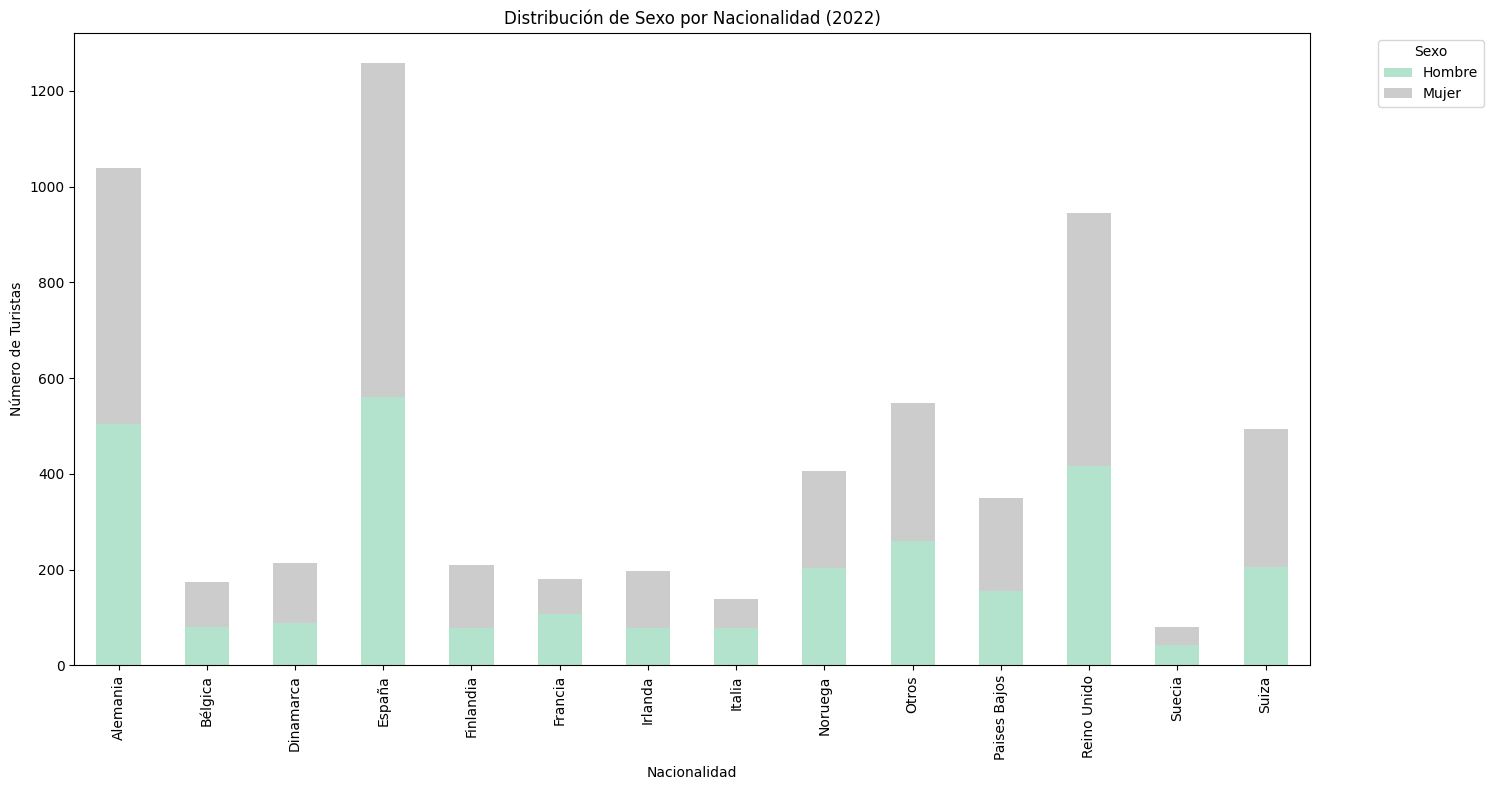

In [182]:
#Sexo por nacionalidad 2022
funciones.grafico_sexo_por_nacionalidad_2022(df_perfil_turistico, año=2022)

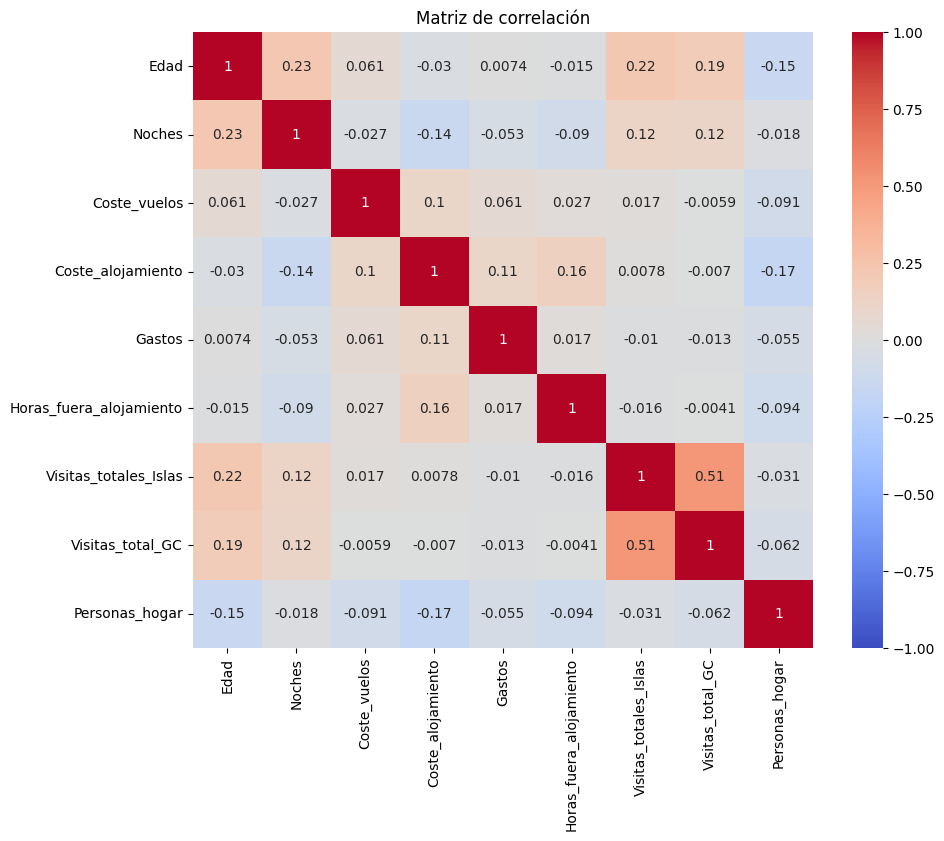

In [183]:
# Calcular la matriz de correlación
correlation_matrix = df_2022[variables_numericas].corr()

#Matriz correlaciones
funciones.matriz_correlacion(correlation_matrix)

Tonos cálidos (rojo) indican correlaciones positivas fuertes (próximas a 
1
1).
Tonos fríos (azul) indican correlaciones negativas fuertes (próximas a 
−
1
−1).
Tonos blancos o neutros indican correlaciones débiles o inexistentes (próximas a 
0
0).

* Correlaciones a destacar:

Visitas totales a GC vs Visitas totales a las Islas (0.51)

Esto significa que, en general, a medida que aumenta el número de visitas a Gran Canaria, también aumentan las visitas totales a las Islas Canarias. Sin embargo, esta relación no es perfectamente lineal.
Esto tiene sentido ya que Gran Canaria (GC) es una de las principales islas del archipiélago de Canarias, por lo que es razonable que haya una relación entre las visitas a GC y el total de visitas a todas las islas.
Sin embargo, el hecho de que la correlación no sea más alta sugiere que:
Las visitas a otras islas (como Tenerife, Lanzarote, etc.) también contribuyen de manera importante al total.
O que algunos turistas visitan solo otras islas, sin incluir GC en su itinerario.

<Figure size 1200x800 with 0 Axes>

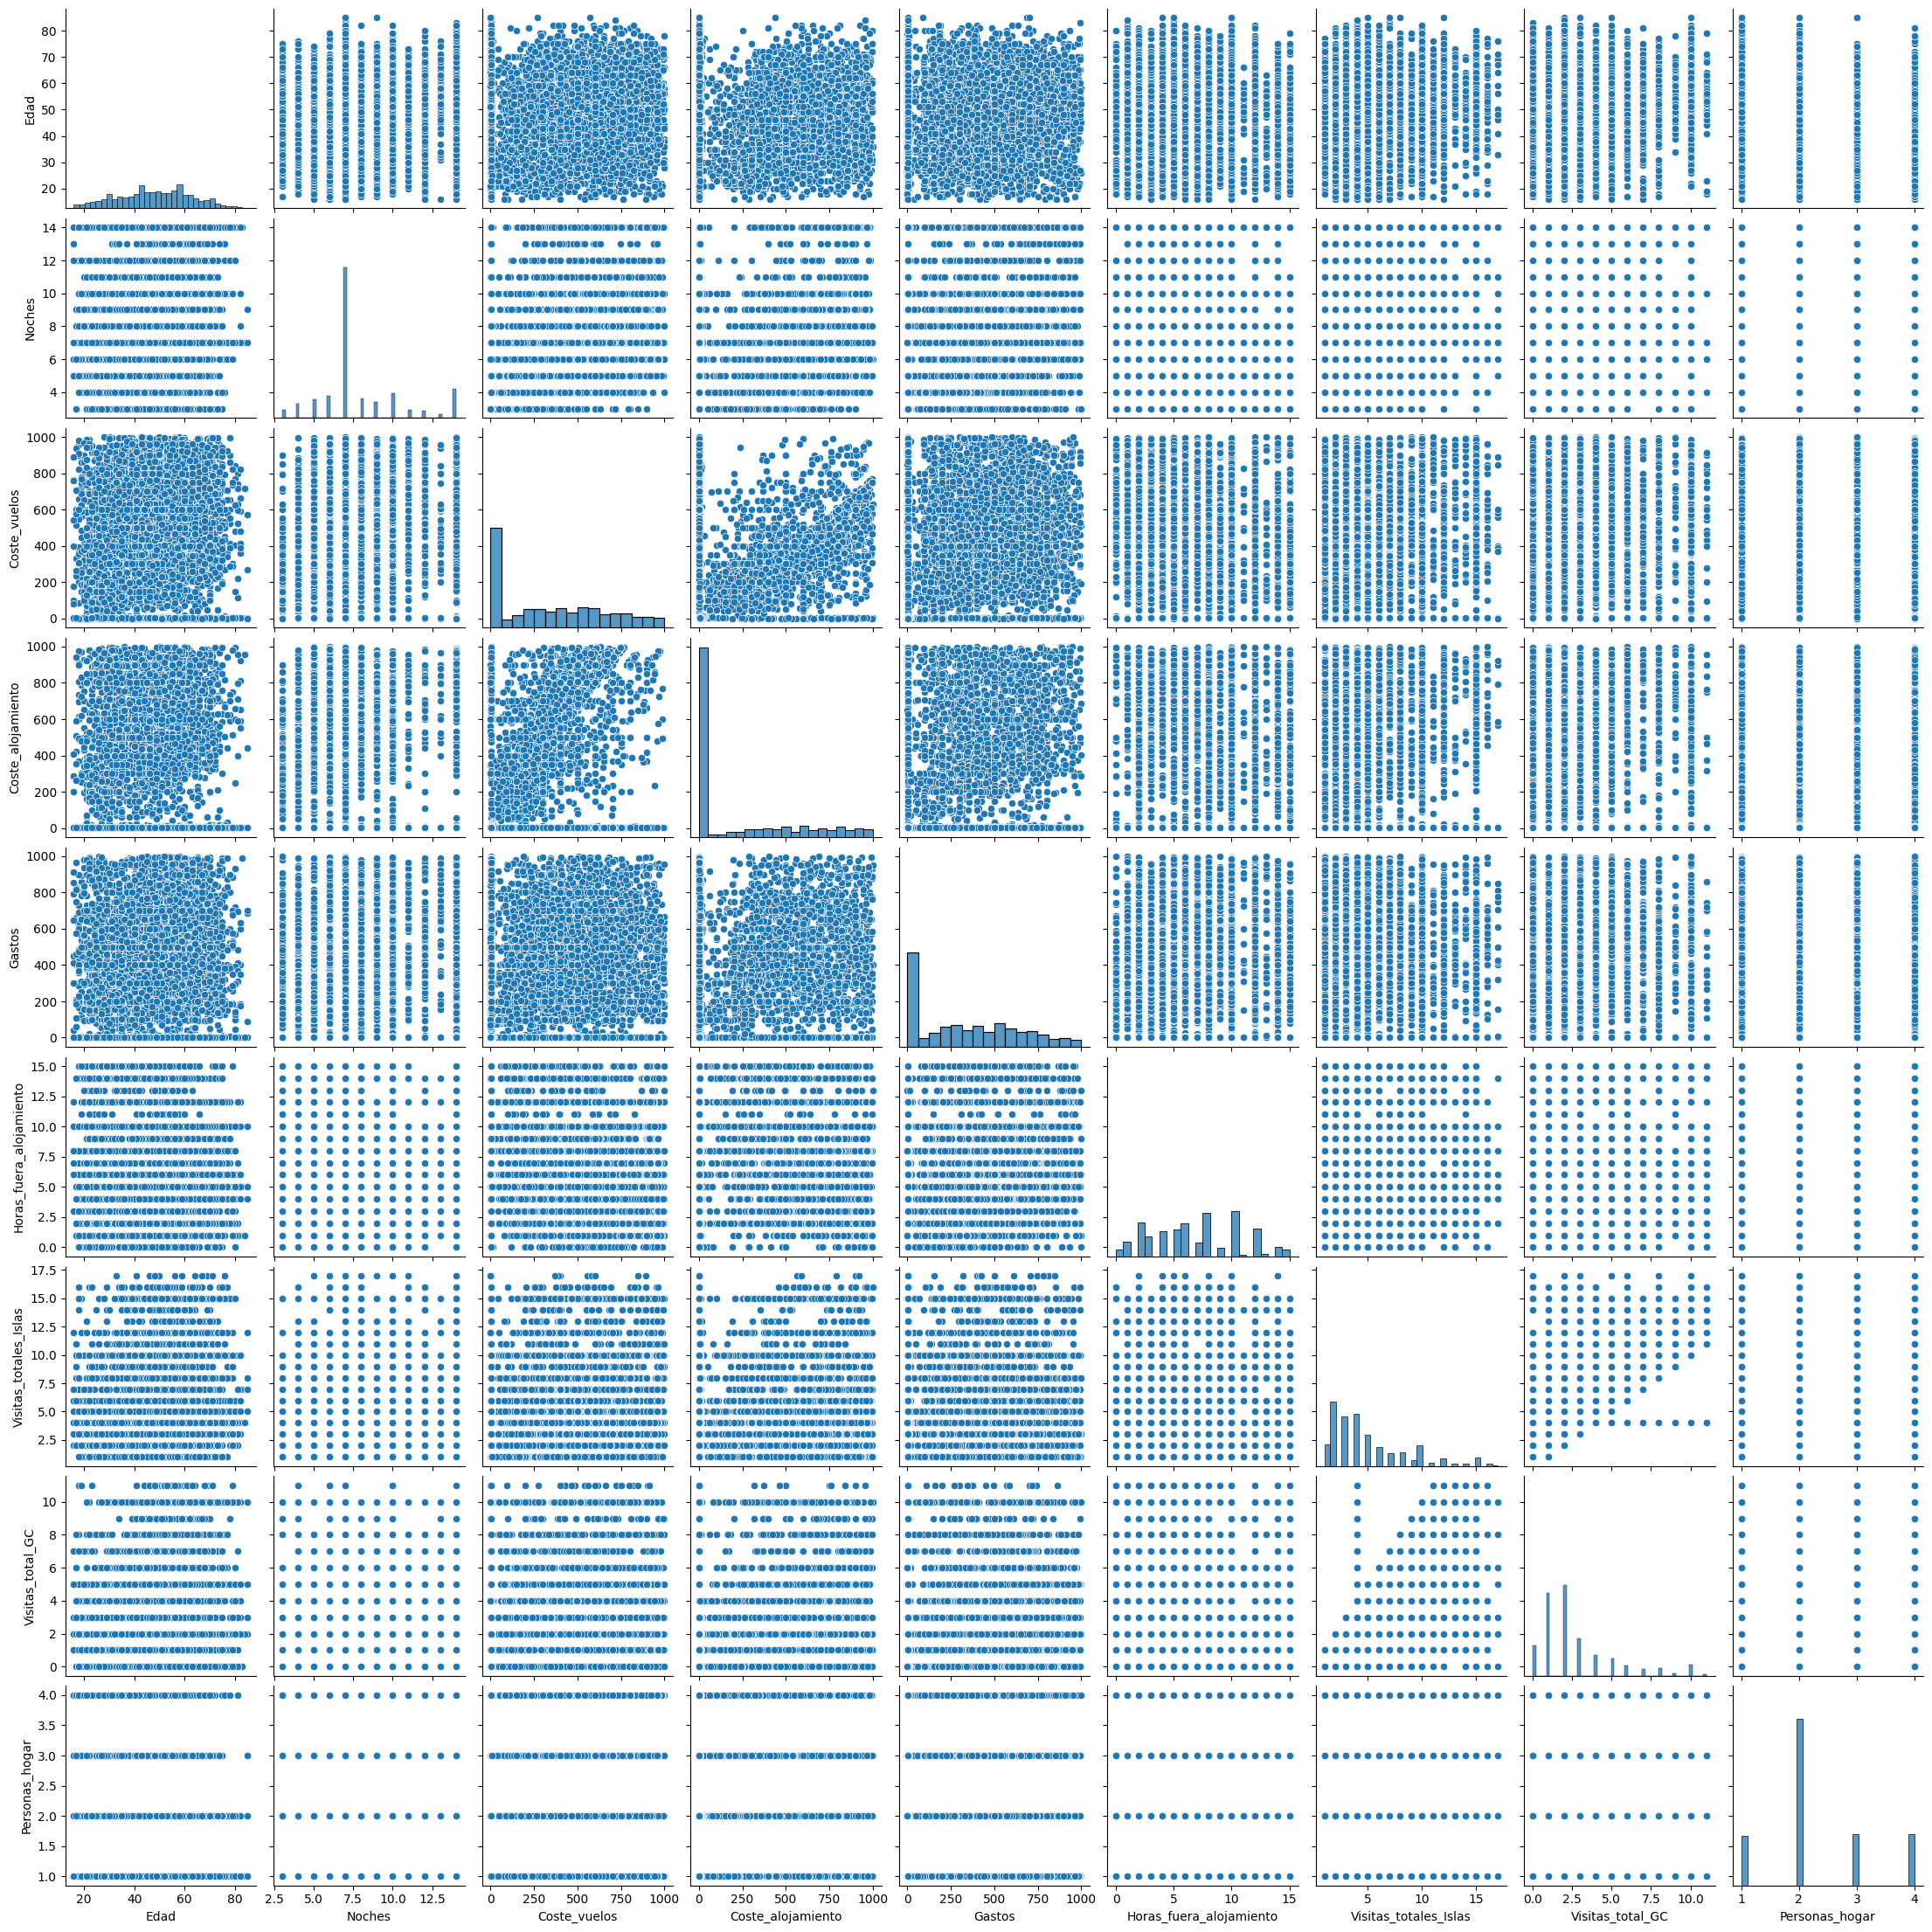

In [184]:
# Visualizar gráficos de dispersión para cada par de variables numéricas
funciones.graficar_dispersión_variables(df_2022, variables_numericas)


# **4. Análisis Multivariante**

Queremos evaluar cómo influyen múltiples variables

Veamos los patrones en los turistas postpandemia, usando el análisis de Componentes Principales (PCA) para reducir la dimensionalidad y encontrar patrones subyacentes
El Análisis de Componentes Principales (PCA) nos será útil ya que tenemos muchas variables y queremos identificar patrones subyacentes, visualizando los datos en menos dimensiones sin perder demasiada información. 
El PCA agrupa variables correlacionadas y permite identificar los componentes principales que explican la mayor parte de la varianza en los datos.

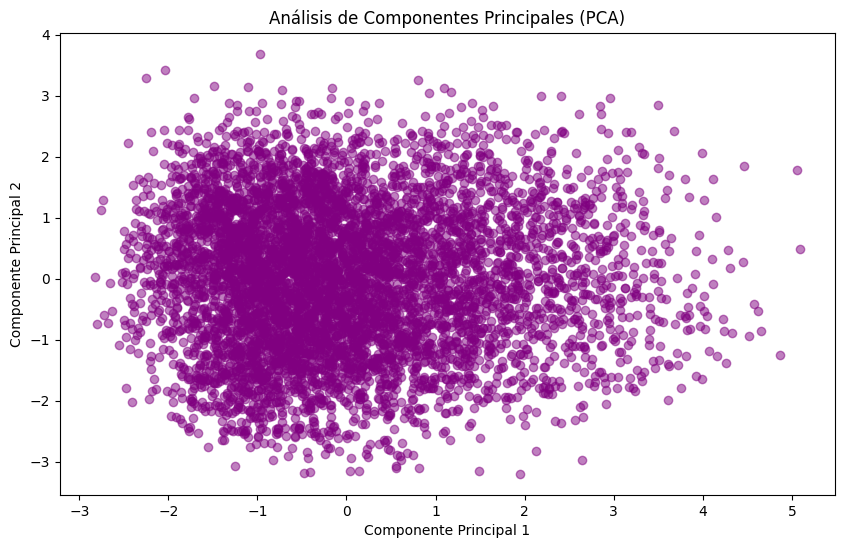

Varianza explicada por los componentes principales:
[0.19518325 0.1578394 ]


In [185]:
# Seleccionamos las columnas numéricas para el análisis PCA
df_pca = df_2022[variables_numericas].dropna()  # Eliminar valores nulos
# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)
# Realizar PCA
pca = PCA(n_components=2)  # Reducir a 2 componentes principales para visualización
pca_components = pca.fit_transform(df_scaled)
# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Graficar los componentes principales
funciones.graficar_PCA(pca_df, pca)
# Mostrar la varianza explicada por cada componente
print("Varianza explicada por los componentes principales:")
print(pca.explained_variance_ratio_)


Este dato implica que dos primeros componentes principales explican:

- El primer componente principal (PC1) explica aproximadamente el 19.5% de la varianza total de los datos. Esto significa que PC1 captura una parte importante de la variabilidad presente en las variables de entrada.

- El segundo componente principal (PC2) explica aproximadamente el 15.8% de la varianza total. Junto con el primer componente, estos dos componentes explican alrededor del 35.3% de la variabilidad total de los datos.

Veamos este analisis en profundidad con los valores asociados a cada componente

In [186]:
# Cargar las cargas (loadings)
loadings = pd.DataFrame(pca.components_, columns=df_cluster.columns, index=['PC1', 'PC2'])

# Mostrar las cargas
print(loadings)


         Edad    Noches  Coste_vuelos  Coste_alojamiento    Gastos  \
PC1  0.448468  0.337488      0.037577          -0.057136 -0.032854   
PC2  0.057337 -0.264658      0.338046           0.582016  0.308613   

     Horas_fuera_alojamiento  Visitas_totales_Islas  Visitas_total_GC  \
PC1                -0.056534               0.576105          0.568032   
PC2                 0.405029               0.042746          0.044602   

     Personas_hogar  
PC1       -0.146521  
PC2       -0.458850  


Componente Principal 1 (PC1):
Edad: La carga positiva en Edad (0.45) sugiere que los turistas más jóvenes tienden a tener estancias más largas, menos gastos y otras características diferentes.
Noches: La carga positiva en Noches (0.34) indica que este componente también está relacionado con la duración de la estancia.
Coste_vuelos y Coste_alojamiento: Las cargas cercanas a 0 (0.04 y -0.06, respectivamente) sugieren que estas variables tienen una influencia muy baja sobre PC1.
Visitas_totales_Islas y Visitas_total_GC: Las cargas positivas (0.58 y 0.57) indican que los turistas que visitan más islas y más veces Gran Canaria.
Personas_hogar: La carga negativa (-0.15) en Personas_hogar sugiere que los turistas de hogares más grandes están asociados a un componente diferente.


Componente Principal 2 (PC2):
Coste_alojamiento: La carga positiva en Coste_alojamiento (0.58) indica que los turistas con estancias de mayor costo de alojamiento están asociados a este componente.
Gastos: La carga positiva en Gastos (0.31) también sugiere que los turistas con un mayor gasto en general están asociados con este componente.
Horas_fuera_alojamiento: La carga positiva (0.41) en Horas_fuera_alojamiento sugiere que este componente está relacionado con turistas que pasan más tiempo fuera del alojamiento.
Visitas_totales_Islas y Visitas_total_GC: Las cargas son bajas o casi nulas (0.04 y 0.04), indicando que las visitas a las islas o a Gran Canaria no influyen demasiado en este componente.
Edad: La carga pequeña (0.06) en Edad sugiere que la edad no tiene una fuerte relación con este componente.
Personas_hogar: La carga negativa (-0.46) en Personas_hogar sugiere que los turistas que vienen de hogares más grandes están asociados con este componente.


Resumen y posibles interpretaciones:
PC1 está relacionado principalmente con el número de visitas a las islas y a Gran Canaria, con turistas más jóvenes y con estancias más largas por lo que se asocia a turistas que tienen estancias largas y un mayor número de visitas a diferentes islas, pero que no necesariamente gastan mucho dinero.

PC2 está más relacionado con el coste de alojamiento, el gasto total y las horas fuera del alojamiento. Este componente parece capturar a los turistas que gastan más en su viaje, ya sea en alojamiento o en otros gastos, y que probablemente están más interesados en actividades fuera del alojamiento.

Por lo que se podría concluir que se podría identificar patrones por dos grandes grupos, turistas "de bajo coste" (relacionados con PC1) y los turistas "de lujo" o "aventureros" (relacionados con PC2).


Ahora bien, analisemos el clustering que es una técnica de análisis multivariante que se utiliza para agrupar a los turistas en segmentos según sus características comunes.

Objetivo del análisis de clustering:

Identificar grupos de turistas con características similares que podrían requerir diferentes estrategias de marketing o servicios turísticos.
Determinar qué variables (por ejemplo, tipo de alojamiento, duración de la estancia, gasto) son las más influyentes para segmentar a los turistas.

C:\Users\Carol\AppData\Local\Temp\ipykernel_18256\3975136339.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Cluster'] = kmeans.labels_


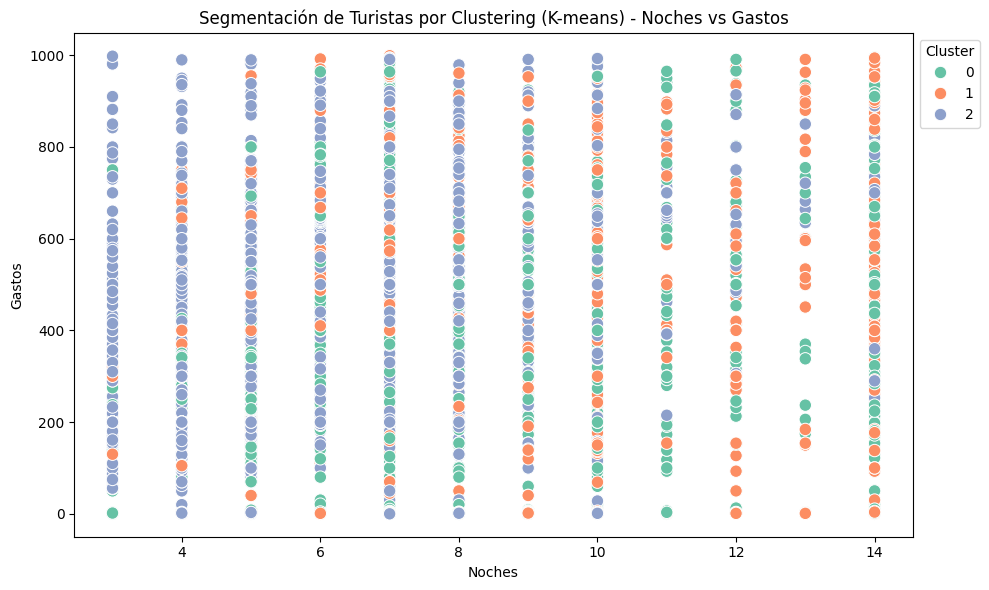

Cluster
2    2656
0    2146
1    1432
Name: count, dtype: int64


In [187]:
# Seleccionar las columnas numéricas para el análisis de clustering
columnas_cluster = ['Edad', 'Noches', 'Coste_vuelos', 'Coste_alojamiento', 'Gastos', 
                    'Horas_fuera_alojamiento', 'Visitas_totales_Islas', 'Visitas_total_GC', 'Personas_hogar']
df_cluster = df_2022[columnas_cluster].dropna()  # Eliminar valores nulos

# Estandarizar los datos
scaler = StandardScaler()
df_scaled_cluster = scaler.fit_transform(df_cluster)

# Aplicar K-means con un número específico de clusters (por ejemplo, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled_cluster)

# Añadir los clusters al DataFrame original
df_2022['Cluster'] = kmeans.labels_

#Gráfico
funciones.graficar_clusters(df_2022, 'Noches', 'Gastos', 'Cluster')

# Ver el número de turistas en cada cluster
print(df_2022['Cluster'].value_counts())


Los resultados del clustering indican que se han identificado 3 clusters de turistas. 
Estos clusters representan grupos de turistas con características similares basadas en las variables que utilizaste para el análisis de clustering (K-means). 

Con ello, el siguiente paso es interpretar los clusters:
Analizar las características de cada cluster: Examina los promedios o distribuciones de las variables originales para cada uno de los clusters. Esto te dará una idea de las características distintivas de cada grupo de turistas. Por ejemplo:

¿Son los turistas del Cluster 2 más jóvenes o tienen estancias más largas que los de los otros clusters?
¿El Cluster 1 tiene un mayor gasto en alojamiento o vuelos?
Puedes hacerlo calculando los promedios de las variables clave por cluster.

In [188]:
# Seleccionar solo las columnas numéricas
numerical_columns = df_2022.select_dtypes(include=['float64', 'int64'])

# Agrupar por 'Cluster' y calcular la media para las columnas numéricas
cluster_profile = df_2022.groupby('Cluster')[numerical_columns.columns].mean()

# Mostrar el perfil de cada cluster
print(cluster_profile)


              Edad    Noches  Coste_vuelos  Coste_alojamiento      Gastos  \
Cluster                                                                     
0        46.359739  8.532153    184.769409          37.989683  257.593408   
1        56.293296  8.851257    406.947506         242.117498  356.235008   
2        45.027861  6.829819    457.036095         390.215825  401.798398   

         Horas_fuera_alojamiento  Visitas_totales_Islas  Visitas_total_GC  \
Cluster                                                                     
0                       5.099720               3.902144          1.952470   
1                       6.849162               9.789804          5.714385   
2                       8.048569               3.466867          1.693901   

         Personas_hogar     Año  
Cluster                          
0              2.900746  2022.0  
1              2.128492  2022.0  
2              1.967244  2022.0  


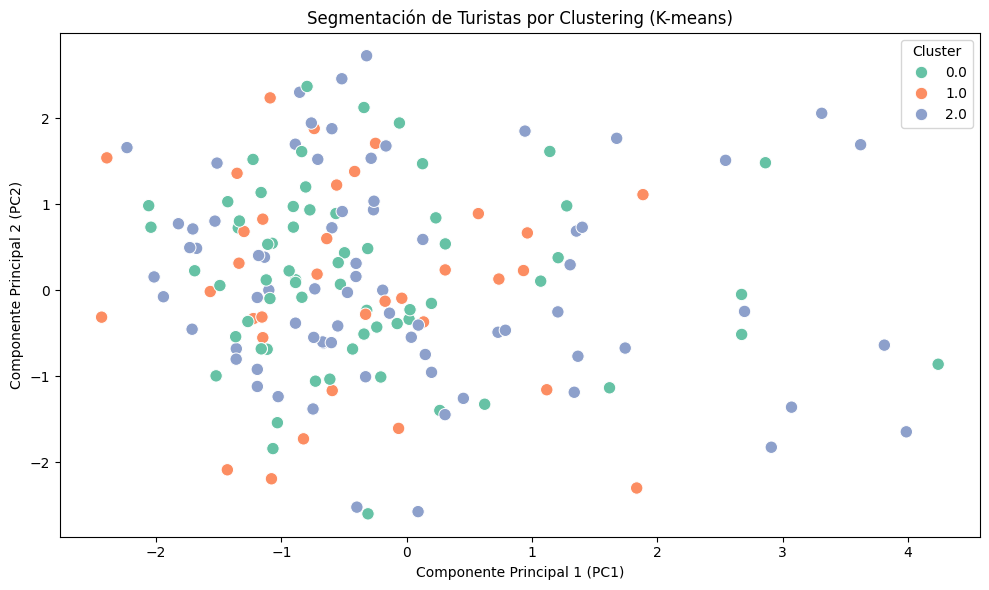

In [189]:
funciones.graficar_clusters_pca(pca_df, df_2022, 'Cluster')

Análisis de los resultados por Cluster
De acuerdo con los valores medios que has proporcionado para cada Cluster (0, 1 y 2), podemos hacer algunas observaciones generales:

|Variable|Cluster 0|Cluster 1|Cluster 2|
|-|-|-|-|
|Edad promedio| 46.36 años|56.29 años|45.03 años|
|Duración de la estancia| 8.53 noches|8.85 noches|6.83 noches|
|Coste de los vuelos| 184.77 EUR|406.95 EUR|457.04 EUR|
|Coste de alojamiento| 37.99 EUR|242.12 EUR|390.22 EUR|
|Gastos totales| 257.59 EUR|356.24 EUR|401.80 EUR|
|Horas fuera del alojamiento| 5.10 horas| 6.85 horas|8.05 horas|
|Visitas a las Islas| 3.90|9.79|3.47|
|Visitas a Gran Canaria:| 1.95|5.71|1.69|
|Personas por hogar| 2.90|2.13|1.97|


Interpretación de los Resultados:

Cluster 0:
Los turistas en este cluster parecen ser de edad intermedia (46 años).
Tienen una estancia promedio de 8.5 noches.
Los costes de vuelos son relativamente bajos, mientras que el coste de alojamiento también es bajo comparado con otros clusters.
Pasan unas 5 horas fuera del alojamiento al día.
Este cluster tiene un número moderado de visitas tanto a las Islas como a Gran Canaria.

Cluster 1:
Este grupo tiene la edad promedio más alta (56 años).
A pesar de tener una duración similar de estancia a Cluster 0, los costes de vuelo y alojamiento son considerablemente más altos.
Gastan más, lo que podría indicar que son turistas más orientados a experiencias premium o de lujo.
Pasan más horas fuera del alojamiento (6.8 horas).
Tienen más visitas a las Islas, lo que podría indicar un interés más profundo en explorar la región.

Cluster 2:
Este cluster tiene turistas con una edad promedio más baja (45 años).
Aunque tienen una estancia ligeramente más corta (6.8 noches), los costes de vuelos y alojamiento son muy altos.
Tienen una mayor cantidad de horas fuera del alojamiento (8 horas).
Visitan menos la isla en comparación con los otros clusters, lo que sugiere que su interés podría estar más centrado en actividades fuera del alojamiento o en otras áreas.